# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки:</b>

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

<b>Целевой признак:</b>

    Price — цена (евро)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb

In [2]:
from catboost import CatBoostRegressor

## Подготовка данных

In [3]:
#Импортируем необходимые библиотеки
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
import numpy as np
from numpy.linalg import inv
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
#Посмотрим на данные
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

def lookup(data):
    print(data.info())
    print()
    print(data.head(10))
    print()
    print(data.duplicated().sum())
    print()
    print(data.nunique())
    print()
    print(data.isna().sum())

lookup(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

И так:

    - NumberOfPictures - колонка говорит, о том что ни у одного автомобиля нет ни одной фотографии. Конкретно в такой выборке эта колонка бессмыслена для обучения.
    - Огромное количество пропусков в VehicleType, Gearbox, Model, FuelType, NotRepaired. Даные всех этих колонок категориальные. Отсутствие категории тоже категория. Далее поправим.
    - 4 Полных дубля на всю выборку. Очень маленькое число, можно пропустить.
    - Типы данных очень разные. Есть даты. Ох уж эти даты. Колонка Brand категориальные данные типа object.

In [5]:
# Уберем колонку NumberOfPictures

df_clean = df.drop(['NumberOfPictures'],axis=1)

#Представим даныне в VehicleType, Gearbox, Model, FuelType, NotRepaired, Brand
#интовыми категориями (почему бы и нет)
#Пропуски сделаем категорией

def categorize(data, column):
    data[column] = data[column].fillna('propuskov.net')
    data[column] = pd.Categorical(data[column], categories=data[column].unique()).codes
    data[column] = data[column].astype(int)
        
categorize(df_clean, 'VehicleType')
categorize(df_clean, 'Gearbox')
categorize(df_clean, 'FuelType')
categorize(df_clean, 'Model')
categorize(df_clean, 'NotRepaired')
categorize(df_clean, 'Brand')

#Удалим следующие колонки:
#DateCrawled — дата скачивания анкеты из базы
#DateCreated — дата создания анкеты
#LastSeen — дата последней активности пользователя
#PostalCode - почтовый индекс владельца анкеты (пользователя)
#Избыточные признаки не несут информации для модели обучения и увеличивают время обучения.

df_clean = df_clean.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Price              354369 non-null  int64
 1   VehicleType        354369 non-null  int64
 2   RegistrationYear   354369 non-null  int64
 3   Gearbox            354369 non-null  int64
 4   Power              354369 non-null  int64
 5   Model              354369 non-null  int64
 6   Kilometer          354369 non-null  int64
 7   RegistrationMonth  354369 non-null  int64
 8   FuelType           354369 non-null  int64
 9   Brand              354369 non-null  int64
 10  NotRepaired        354369 non-null  int64
dtypes: int64(11)
memory usage: 29.7 MB
None


In [6]:
# Посмотрим на столбец RegistrationMonth
sorted(df_clean.RegistrationMonth.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
#Т.к. 0 недопустимое значение признака RegistrationMonth, и, вероятно, возникло из за того, 
#что владелец не указал месяц регистрации авто, заменим на Январь(т.е. 1):

df_clean.RegistrationMonth = df_clean.RegistrationMonth.replace(0, 1, inplace=False)
sorted(df_clean.RegistrationMonth.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [8]:
## Посмотрим на столбец RegistrationYear
sorted(df_clean.RegistrationYear.unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [9]:
#Выведем df с признаком RegistrationYear, у которого год указан аномальным значением:

invalid_year = df_clean[(df_clean.RegistrationYear < 1910) | (df_clean.RegistrationYear > 2019)]
invalid_year

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
622,0,0,1111,2,0,1,5000,1,2,11,0
12946,49,0,5000,2,0,0,5000,12,2,0,0
15147,0,0,9999,2,0,1,10000,1,2,19,0
15870,1700,0,3200,2,0,1,5000,1,2,19,0
16062,190,0,1000,2,0,76,5000,1,2,6,0
...,...,...,...,...,...,...,...,...,...,...,...
340548,0,0,3500,0,75,1,5000,3,0,19,0
340759,700,0,1600,0,1600,69,150000,4,0,1,2
341791,1,0,3000,2,0,74,5000,1,2,11,0
348830,1,0,1000,2,1000,1,150000,1,2,19,0


In [10]:
#Количество объектов 171, что составляет < 0.01 % всех объектов. 
#Удалим объекты с аномальными значениями по индексам.

df_clean.drop(invalid_year.index, inplace=True)

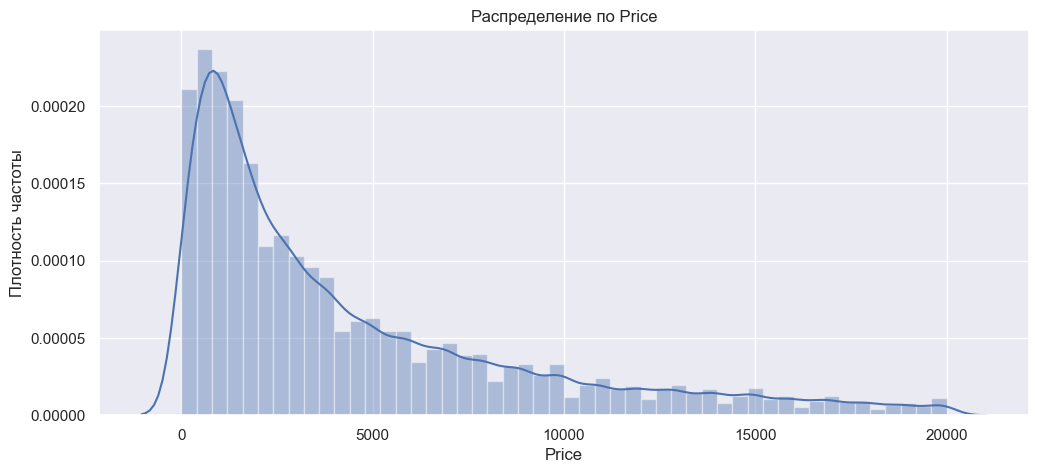

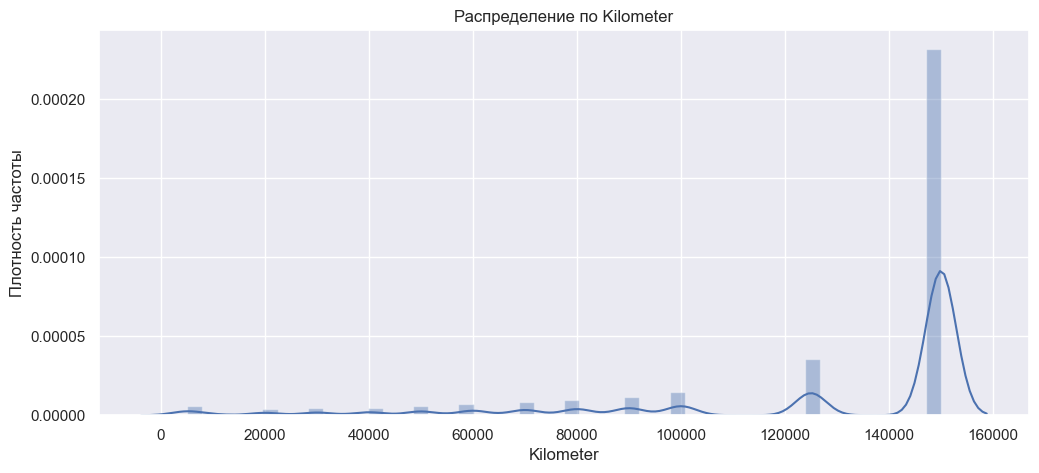

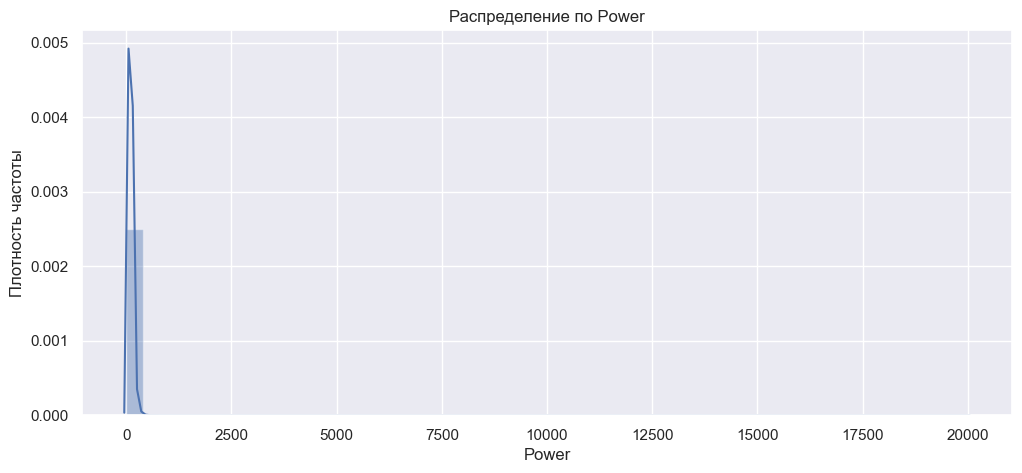

In [11]:
#Посмотрим на колонки Price, Power, Kilometer

numeric_feature = set(('Price', 'Power', 'Kilometer'))
def numeric_feature_distribution(column):
    sns.set()
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.distplot(df_clean[column])
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Плотность частоты');

[numeric_feature_distribution(item) for item in numeric_feature];

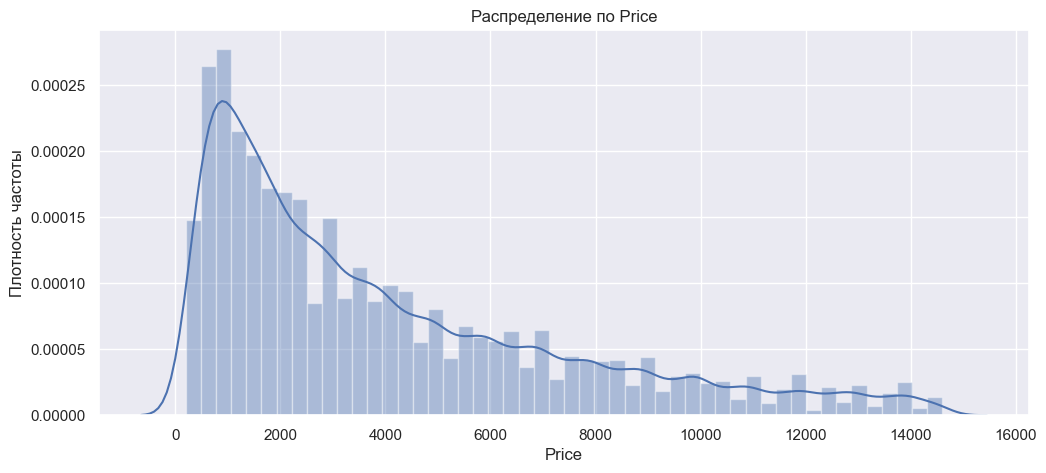

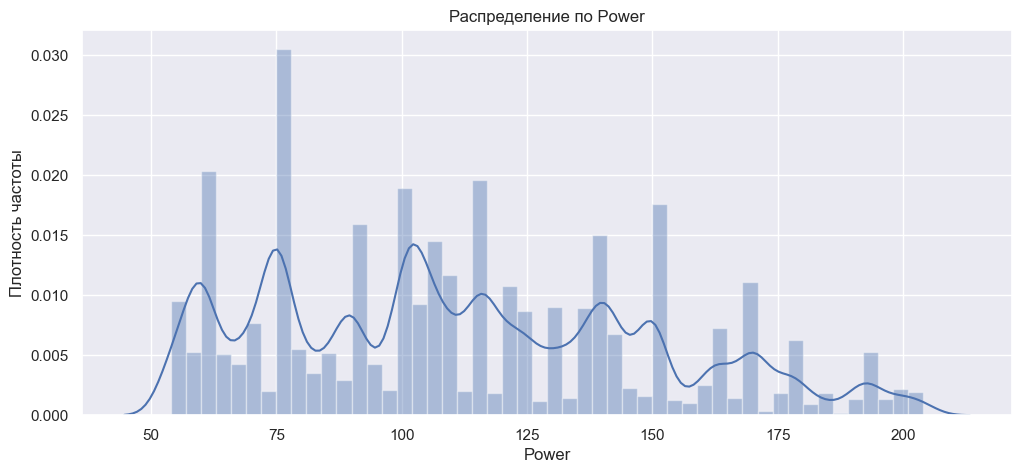

In [12]:
#Признак Kilometer относиться больше к категориальным признакам, удалим из переменной:
numeric_feature.discard('Kilometer')
numeric_feature

#Посмотрим на распределения в признаке Price:
df_clean.Price.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])
#Ограничим распределение 5% и 95% квантилями, исключив аномальные значения:
invalid_price = df_clean[(df_clean.Price < df_clean.Price.quantile(.05)) | (df_clean.Price > df_clean.Price.quantile(.95))]
invalid_price.shape
df_clean.drop(invalid_price.index, inplace=True)

#Посмотрим на распределения в признаке Power:
df_clean.Power.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])
#Мощность двигателя ниже 15% и выше 95% квантилей, является аномальным. Удалим их из респределения:
invalid_power = df_clean[(df_clean.Power < df_clean.Power.quantile(.15)) | (df_clean.Power > df_clean.Power.quantile(.95))]
invalid_power.shape
df_clean.drop(invalid_power.index, inplace=True)

#Снова построим графики количественных признаков:
[numeric_feature_distribution(item) for item in numeric_feature];

In [13]:
#Чтобы преобразовать категориальные признаки в численные поможет техника прямого кодирования
#(One-Hot Encoding, OHE). Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies()
#чтобы избежать дамми-ловушки, используем аргумент drop_first=True

#Для бустинга сохраним датасет без OHE

df_boost = df_clean.copy()


df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,2,2004,1,163,2,125000,8,1,2,0
3,1500,3,2001,0,75,0,150000,6,0,0,2
4,3600,3,2008,0,69,3,90000,7,1,3,2
5,650,4,1995,0,102,4,150000,10,0,4,1
6,2200,5,2004,0,109,5,150000,8,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,4,2010,0,140,0,150000,7,1,0,2
354361,5250,0,2016,1,150,130,150000,12,2,20,2
354366,1199,5,2000,1,101,29,125000,3,0,17,2
354367,9200,6,1996,0,102,21,150000,3,1,0,2


### Вывод:

    Данные предобработаны. Избыточные и аномальные признаки удалены, количественные признаки преобразованы в категориальыне

## Обучение моделей

In [14]:
# Подготовим выборки
# Масштабируем признаки
# Сделаем это конечно же функцией

def preparation(data, point):
    
    train, valid_test = train_test_split(data, test_size=0.4, random_state=12345)
    valid, test = train_test_split(valid_test, test_size=0.5, random_state=12345)
    
    def features_target_split(data, point):
        features = data.drop([point], axis=1)
        target = data[point]
        return features, target

    train_features, train_target = features_target_split(train, point)
    valid_features, valid_target = features_target_split(valid, point)
    test_features, test_target = features_target_split(test, point)
    
    def data_to_StandardScaler(data, train_features):
        scaler = StandardScaler()
        scaler.fit(train_features)
        data = scaler.transform(data)
        return data
    
    valid_features_scale = data_to_StandardScaler(valid_features, train_features)
    train_features_scale = data_to_StandardScaler(train_features, train_features)
    test_features_scale = data_to_StandardScaler(test_features, train_features)
    
    return train_target, valid_target, test_target,valid_features_scale, train_features_scale, test_features_scale

#train_target, valid_target, test_target,valid_features_scale, train_features_scale, test_features_scale = preparation(df_clean, 'Price')

#Подготовим код метрики

def rmse(predict, target):
    mse = mean_squared_error(target, predict)
    rmse = mse ** 0.5
    return rmse
    
score = make_scorer(rmse, greater_is_better=False)    

In [15]:
%%time

# Посмотрим на решающее дерево
# Для начала подберем параметры

def tree(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
    parameters_grid = {}
    
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

tree(df_clean, 'Price')
    

-2015.3364596165056
{}
CPU times: user 6.07 s, sys: 925 ms, total: 6.99 s
Wall time: 18.4 s


In [16]:
#Проверим скорость и качество Решающего дерева по лучшим параметрам

def tree_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', 
                               criterion='entropy', max_depth = 3, min_samples_leaf = 5, 
                               min_samples_split = 2)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

tree_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 174 ms, sys: 4.17 ms, total: 178 ms
Wall time: 181 ms
----------
Скорость предсказания:
CPU times: user 78.8 ms, sys: 84 ms, total: 163 ms
Wall time: 164 ms
----------
RMSE модели : 4787.00
----------
RMSE модели на тестовой выборке : 4799.70
----------
RMSE модели(кросс-валидация) : 4654.44
----------
Скорость обучения дамми-модели:
CPU times: user 7.31 ms, sys: 592 µs, total: 7.9 ms
Wall time: 8.26 ms
----------
Скорость предсказания дамми-модели:
CPU times: user 894 µs, sys: 237 µs, total: 1.13 ms
Wall time: 1.37 ms
----------
RMSE дамми-модели : 5545.80


In [17]:
%%time

# Посмотрим на случайный лес
# Подберем параметры
# Тут мой ноут откровенно дал дубу, так что, для подбора параметров, я немжко сократил датасет в 10 раз

def forest(data,point):
    data = data.sample(frac = 0.1, random_state=12345)
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = RandomForestClassifier(random_state=12345, class_weight='balanced')
    parameters_grid = {
    'n_estimators' : range(5, 101, 5),
    'max_depth' : range(1, 11)
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

forest(df_clean, 'Price')

-2971.003045157606
{'max_depth': 10, 'n_estimators': 95}
CPU times: user 3.49 s, sys: 1.16 s, total: 4.65 s
Wall time: 2min 56s


In [18]:
#Проверим скорость и качество Случайного леса по лучшим параметрам

def forest_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', 
                               criterion='entropy', max_depth = 10, n_estimators = 95)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

forest_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 23.5 s, sys: 707 ms, total: 24.3 s
Wall time: 24.7 s
----------
Скорость предсказания:
CPU times: user 25.7 s, sys: 33.3 s, total: 58.9 s
Wall time: 1min 21s
----------
RMSE модели : 2386.74
----------
RMSE модели на тестовой выборке : 2416.41
----------
RMSE модели(кросс-валидация) : 2406.51
----------
Скорость обучения дамми-модели:
CPU times: user 7.03 ms, sys: 1.57 ms, total: 8.6 ms
Wall time: 12.6 ms
----------
Скорость предсказания дамми-модели:
CPU times: user 854 µs, sys: 663 µs, total: 1.52 ms
Wall time: 3.31 ms
----------
RMSE дамми-модели : 5545.80


In [19]:
%%time

# Посмотрим на регресивное дерево


def tree_regressor(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = DecisionTreeRegressor(random_state=12345)
    parameters_grid = {
    'max_depth' : range(1,6),
    'min_samples_leaf': range(1,6),
    'min_samples_split': range(1,6),
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

tree_regressor(df_clean, 'Price')

-1990.4531821366252
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: user 845 ms, sys: 757 ms, total: 1.6 s
Wall time: 20.1 s


In [20]:
#Проверим скорость и качество Дерево регрессии по лучшим параметрам

def tree_regressor_check(data,point):
    (train_target, 
         valid_target,
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = DecisionTreeRegressor(random_state=12345, 
                               criterion='squared_error', max_depth = 5, min_samples_leaf = 1, 
                               min_samples_split = 2)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

tree_regressor_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 151 ms, sys: 2.74 ms, total: 154 ms
Wall time: 155 ms
----------
Скорость предсказания:
CPU times: user 2.46 ms, sys: 519 µs, total: 2.97 ms
Wall time: 3.11 ms
----------
RMSE модели : 1947.30
----------
RMSE модели на тестовой выборке : 1974.94
----------
RMSE модели(кросс-валидация) : 1982.36
----------
Скорость обучения дамми-модели:
CPU times: user 276 µs, sys: 166 µs, total: 442 µs
Wall time: 808 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 40 µs, sys: 3 µs, total: 43 µs
Wall time: 45.1 µs
----------
RMSE дамми-модели : 3419.21


In [21]:
%%time

# Посмотрим на регрессивный лес
# И тут мой ноут откровенно дал дубу, так что, для подбора параметров, я немжко сократил датасет в 10 раз


def forest_regressor(data,point):
    data = data.sample(frac = 0.1, random_state=12345)
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = RandomForestRegressor(random_state=12345)
    parameters_grid = {
    'n_estimators' : range(5, 101, 5),
    'max_depth' : range(1, 11)
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

forest_regressor(df_clean, 'Price')

-1552.4527020764642
{'max_depth': 10, 'n_estimators': 100}
CPU times: user 2.93 s, sys: 387 ms, total: 3.32 s
Wall time: 1min 2s


In [22]:
#Проверим скорость и качество Леса регрессий по лучшим параметрам

def forest_regressor_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = RandomForestRegressor(random_state=12345, 
                               criterion='squared_error', max_depth = 10,
                                  n_estimators = 100, n_jobs =-1)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

forest_regressor_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 26 s, sys: 494 ms, total: 26.4 s
Wall time: 4.55 s
----------
Скорость предсказания:
CPU times: user 486 ms, sys: 13.8 ms, total: 500 ms
Wall time: 96.8 ms
----------
RMSE модели : 1491.80
----------
RMSE модели на тестовой выборке : 1513.61
----------
RMSE модели(кросс-валидация) : 1514.40
----------
Скорость обучения дамми-модели:
CPU times: user 234 µs, sys: 29 µs, total: 263 µs
Wall time: 266 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 56 µs, sys: 129 µs, total: 185 µs
Wall time: 423 µs
----------
RMSE дамми-модели : 3419.21


In [23]:
# Посмотрим на линейную регрессию


def line_regressor(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LinearRegression(n_jobs=-1)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

line_regressor(df_clean, 'Price')

Скорость обучения:
CPU times: user 78.5 ms, sys: 54.7 ms, total: 133 ms
Wall time: 136 ms
----------
Скорость предсказания:
CPU times: user 13.5 ms, sys: 14.5 ms, total: 28 ms
Wall time: 5.74 ms
----------
RMSE модели : 2389.45
----------
RMSE модели на тестовой выборке : 2402.92
----------
RMSE модели(кросс-валидация) : 2407.02
----------
Скорость обучения дамми-модели:
CPU times: user 756 µs, sys: 770 µs, total: 1.53 ms
Wall time: 264 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 140 µs, sys: 96 µs, total: 236 µs
Wall time: 41 µs
----------
RMSE дамми-модели : 3419.21


In [24]:
#Посмотрим на бустинг в lightGBM, подберем параметры

from lightgbm import LGBMRegressor

df_boost_lgbm = df_boost.copy()
cols = ["VehicleType", "RegistrationYear", "Gearbox", "Kilometer", 
        "Model", "RegistrationMonth", "FuelType", "Brand", "NotRepaired"]

for item in cols:
    df_boost_lgbm[item] = df_boost_lgbm[item].astype("category").cat.codes +1


def lgb_boost(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LGBMRegressor(boosting_type='gbdt' , random_state = 12345, 
                          njob=-1,)
    parameters_grid = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [50, 100, 200, 500, 1000]
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

lgb_boost(df_boost_lgbm, 'Price')

[LightGBM] [Warning] Unknown parameter: njob
-1271.4772769360834
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}


In [25]:
#Проверим скорость и качество бустинг в lightGBM по лучшим параметрам

def lgb_boost_check(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LGBMRegressor(boosting_type='gbdt', random_state = 12345, njob=-1, learning_rate = 0.1, max_depth = 6, n_estimators = 1000)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

lgb_boost_check(df_boost_lgbm, 'Price')

Скорость обучения:
CPU times: user 22.7 s, sys: 9.65 s, total: 32.4 s
Wall time: 7.55 s
----------
Скорость предсказания:
CPU times: user 4.12 s, sys: 42 ms, total: 4.17 s
Wall time: 645 ms
----------
RMSE модели : 1245.37
----------
[LightGBM] [Warning] Unknown parameter: njob
RMSE модели на тестовой выборке : 1258.32
----------
[LightGBM] [Warning] Unknown parameter: njob
[LightGBM] [Warning] Unknown parameter: njob
[LightGBM] [Warning] Unknown parameter: njob
RMSE модели(кросс-валидация) : 1273.21
----------
Скорость обучения дамми-модели:
CPU times: user 1.84 ms, sys: 1.92 ms, total: 3.76 ms
Wall time: 870 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 268 µs, sys: 246 µs, total: 514 µs
Wall time: 105 µs
----------
RMSE дамми-модели : 3419.21


In [26]:
#Посмотрим на CatBoost

df_boost_cat = df_boost.copy()

def cat_boost_check(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = CatBoostRegressor(random_state = 12345, one_hot_max_size = 12)
    parameters_grid = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [50, 100, 200]
    }
    grid_search_result = model.grid_search(parameters_grid, 
                                                X=train_features_scale, 
                                                y=train_target, 
                                                plot=True)
    model.get_params()
    model.get_best_score()
    %time model.fit(train_features_scale, train_target, verbose=10,)
    %time prediction = model.predict(test_features_scale)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))

cat_boost_check(df_boost_cat, 'Price')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5143.2276939	test: 5172.7320877	best: 5172.7320877 (0)	total: 69ms	remaining: 3.38s
1:	learn: 5027.5928516	test: 5056.7746055	best: 5056.7746055 (1)	total: 77.6ms	remaining: 1.86s
2:	learn: 4915.7924543	test: 4944.6541542	best: 4944.6541542 (2)	total: 82.6ms	remaining: 1.29s
3:	learn: 4807.4967215	test: 4835.9845091	best: 4835.9845091 (3)	total: 87.3ms	remaining: 1s
4:	learn: 4704.6965057	test: 4732.8143696	best: 4732.8143696 (4)	total: 91.5ms	remaining: 823ms
5:	learn: 4605.4432420	test: 4633.5493876	best: 4633.5493876 (5)	total: 96.3ms	remaining: 706ms
6:	learn: 4508.7802081	test: 4536.5837890	best: 4536.5837890 (6)	total: 101ms	remaining: 618ms
7:	learn: 4415.5145164	test: 4443.2262583	best: 4443.2262583 (7)	total: 105ms	remaining: 550ms
8:	learn: 4326.9264068	test: 4354.6200581	best: 4354.6200581 (8)	total: 110ms	remaining: 501ms
9:	learn: 4242.6480327	test: 4270.1613156	best: 4270.1613156 (9)	total: 121ms	remaining: 483ms
10:	learn: 4159.5011242	test: 4186.7456917	best: 

49:	learn: 1856.8972694	test: 1875.2405959	best: 1875.2405959 (49)	total: 323ms	remaining: 0us

bestTest = 1875.240596
bestIteration = 49

1:	loss: 1875.2405959	best: 1875.2405959 (1)	total: 733ms	remaining: 32.2s
0:	learn: 5143.2381942	test: 5172.7426725	best: 5172.7426725 (0)	total: 5.49ms	remaining: 269ms
1:	learn: 5027.6121733	test: 5056.7940593	best: 5056.7940593 (1)	total: 12ms	remaining: 289ms
2:	learn: 4915.8186560	test: 4944.6804910	best: 4944.6804910 (2)	total: 17.9ms	remaining: 281ms
3:	learn: 4807.5302438	test: 4836.0181774	best: 4836.0181774 (3)	total: 24ms	remaining: 276ms
4:	learn: 4704.7360604	test: 4732.8541046	best: 4732.8541046 (4)	total: 30ms	remaining: 270ms
5:	learn: 4605.4861660	test: 4633.5925086	best: 4633.5925086 (5)	total: 35.4ms	remaining: 260ms
6:	learn: 4508.8310435	test: 4536.6349085	best: 4536.6349085 (6)	total: 42.2ms	remaining: 259ms
7:	learn: 4415.5686677	test: 4443.2807210	best: 4443.2807210 (7)	total: 48ms	remaining: 252ms
8:	learn: 4326.9828639	tes

37:	learn: 1931.7116876	test: 1952.0713194	best: 1952.0713194 (37)	total: 420ms	remaining: 133ms
38:	learn: 1925.1468861	test: 1945.2252356	best: 1945.2252356 (38)	total: 428ms	remaining: 121ms
39:	learn: 1919.0442053	test: 1938.8247106	best: 1938.8247106 (39)	total: 440ms	remaining: 110ms
40:	learn: 1911.2308019	test: 1931.2483883	best: 1931.2483883 (40)	total: 446ms	remaining: 97.9ms
41:	learn: 1903.6260243	test: 1923.9179455	best: 1923.9179455 (41)	total: 454ms	remaining: 86.5ms
42:	learn: 1897.9672203	test: 1917.8041878	best: 1917.8041878 (42)	total: 462ms	remaining: 75.2ms
43:	learn: 1892.0375639	test: 1911.4771047	best: 1911.4771047 (43)	total: 469ms	remaining: 63.9ms
44:	learn: 1887.0363932	test: 1906.4368050	best: 1906.4368050 (44)	total: 474ms	remaining: 52.6ms
45:	learn: 1881.9604950	test: 1901.0553720	best: 1901.0553720 (45)	total: 485ms	remaining: 42.2ms
46:	learn: 1870.8175901	test: 1889.3562158	best: 1889.3562158 (46)	total: 500ms	remaining: 31.9ms
47:	learn: 1865.9807536

28:	learn: 2031.0242503	test: 2051.9628326	best: 2051.9628326 (28)	total: 386ms	remaining: 280ms
29:	learn: 2018.6840794	test: 2039.5330097	best: 2039.5330097 (29)	total: 395ms	remaining: 263ms
30:	learn: 2005.0574048	test: 2026.2935001	best: 2026.2935001 (30)	total: 402ms	remaining: 247ms
31:	learn: 1993.2373747	test: 2014.3954876	best: 2014.3954876 (31)	total: 409ms	remaining: 230ms
32:	learn: 1982.7367005	test: 2004.2957871	best: 2004.2957871 (32)	total: 416ms	remaining: 215ms
33:	learn: 1972.9056848	test: 1994.4062795	best: 1994.4062795 (33)	total: 422ms	remaining: 198ms
34:	learn: 1963.5339367	test: 1984.6715116	best: 1984.6715116 (34)	total: 427ms	remaining: 183ms
35:	learn: 1955.8456820	test: 1976.8392564	best: 1976.8392564 (35)	total: 433ms	remaining: 168ms
36:	learn: 1947.8747073	test: 1968.6788440	best: 1968.6788440 (36)	total: 440ms	remaining: 155ms
37:	learn: 1931.7686599	test: 1952.1298033	best: 1952.1298033 (37)	total: 446ms	remaining: 141ms
38:	learn: 1925.2075935	test: 

24:	learn: 2097.8613580	test: 2119.3292937	best: 2119.3292937 (24)	total: 269ms	remaining: 269ms
25:	learn: 2078.0461643	test: 2098.8961507	best: 2098.8961507 (25)	total: 277ms	remaining: 256ms
26:	learn: 2061.2978855	test: 2082.1748679	best: 2082.1748679 (26)	total: 285ms	remaining: 243ms
27:	learn: 2045.4874641	test: 2066.8447669	best: 2066.8447669 (27)	total: 297ms	remaining: 233ms
28:	learn: 2031.0701620	test: 2052.0096410	best: 2052.0096410 (28)	total: 303ms	remaining: 219ms
29:	learn: 2018.7287764	test: 2039.5783940	best: 2039.5783940 (29)	total: 310ms	remaining: 207ms
30:	learn: 2005.0987724	test: 2026.3355740	best: 2026.3355740 (30)	total: 315ms	remaining: 193ms
31:	learn: 1993.2762855	test: 2014.4350515	best: 2014.4350515 (31)	total: 318ms	remaining: 179ms
32:	learn: 1982.7744321	test: 2004.3342024	best: 2004.3342024 (32)	total: 324ms	remaining: 167ms
33:	learn: 1972.9545859	test: 1994.4563741	best: 1994.4563741 (33)	total: 329ms	remaining: 155ms
34:	learn: 1963.5816196	test: 

10:	learn: 2778.3211474	test: 2799.9766796	best: 2799.9766796 (10)	total: 86.8ms	remaining: 308ms
11:	learn: 2679.6549553	test: 2701.5275894	best: 2701.5275894 (11)	total: 93.4ms	remaining: 296ms
12:	learn: 2599.1220227	test: 2620.5036751	best: 2620.5036751 (12)	total: 102ms	remaining: 289ms
13:	learn: 2520.2130225	test: 2542.5198445	best: 2542.5198445 (13)	total: 108ms	remaining: 278ms
14:	learn: 2453.8896327	test: 2475.7515909	best: 2475.7515909 (14)	total: 116ms	remaining: 271ms
15:	learn: 2396.2332194	test: 2418.7088355	best: 2418.7088355 (15)	total: 145ms	remaining: 308ms
16:	learn: 2346.9595330	test: 2369.0184990	best: 2369.0184990 (16)	total: 154ms	remaining: 299ms
17:	learn: 2304.3278864	test: 2324.8647266	best: 2324.8647266 (17)	total: 159ms	remaining: 283ms
18:	learn: 2265.6752019	test: 2286.4946818	best: 2286.4946818 (18)	total: 165ms	remaining: 270ms
19:	learn: 2229.0590659	test: 2250.2815235	best: 2250.2815235 (19)	total: 171ms	remaining: 257ms
20:	learn: 2197.4864534	test

72:	learn: 2194.8123991	test: 2217.5195347	best: 2217.5195347 (72)	total: 396ms	remaining: 146ms
73:	learn: 2186.0117206	test: 2208.5533858	best: 2208.5533858 (73)	total: 436ms	remaining: 153ms
74:	learn: 2177.8396380	test: 2200.5294305	best: 2200.5294305 (74)	total: 442ms	remaining: 147ms
75:	learn: 2169.8114471	test: 2192.3952760	best: 2192.3952760 (75)	total: 449ms	remaining: 142ms
76:	learn: 2162.5328383	test: 2185.1285669	best: 2185.1285669 (76)	total: 456ms	remaining: 136ms
77:	learn: 2155.6201285	test: 2178.2622044	best: 2178.2622044 (77)	total: 461ms	remaining: 130ms
78:	learn: 2148.2376103	test: 2170.9661266	best: 2170.9661266 (78)	total: 466ms	remaining: 124ms
79:	learn: 2141.4976006	test: 2164.1075028	best: 2164.1075028 (79)	total: 475ms	remaining: 119ms
80:	learn: 2135.1659581	test: 2157.6563697	best: 2157.6563697 (80)	total: 481ms	remaining: 113ms
81:	learn: 2128.2904889	test: 2150.9685831	best: 2150.9685831 (81)	total: 499ms	remaining: 110ms
82:	learn: 2121.4311279	test: 

79:	learn: 1755.3798578	test: 1770.9898211	best: 1770.9898211 (79)	total: 379ms	remaining: 94.8ms
80:	learn: 1754.1322633	test: 1769.6234111	best: 1769.6234111 (80)	total: 390ms	remaining: 91.4ms
81:	learn: 1752.6781730	test: 1767.9886402	best: 1767.9886402 (81)	total: 395ms	remaining: 86.6ms
82:	learn: 1749.2958187	test: 1764.8481523	best: 1764.8481523 (82)	total: 400ms	remaining: 82ms
83:	learn: 1747.5558947	test: 1763.1036749	best: 1763.1036749 (83)	total: 405ms	remaining: 77.1ms
84:	learn: 1744.4569503	test: 1760.0423190	best: 1760.0423190 (84)	total: 410ms	remaining: 72.4ms
85:	learn: 1741.0519285	test: 1756.6087104	best: 1756.6087104 (85)	total: 415ms	remaining: 67.6ms
86:	learn: 1739.9785836	test: 1755.5842112	best: 1755.5842112 (86)	total: 419ms	remaining: 62.6ms
87:	learn: 1738.7122685	test: 1754.4487590	best: 1754.4487590 (87)	total: 424ms	remaining: 57.8ms
88:	learn: 1737.2372606	test: 1752.9254128	best: 1752.9254128 (88)	total: 428ms	remaining: 53ms
89:	learn: 1734.4105078	

83:	learn: 2115.1923953	test: 2138.2010087	best: 2138.2010087 (83)	total: 500ms	remaining: 95.2ms
84:	learn: 2109.4340719	test: 2132.4758046	best: 2132.4758046 (84)	total: 506ms	remaining: 89.2ms
85:	learn: 2103.8216476	test: 2126.7466105	best: 2126.7466105 (85)	total: 518ms	remaining: 84.3ms
86:	learn: 2097.7046956	test: 2120.4813064	best: 2120.4813064 (86)	total: 529ms	remaining: 79.1ms
87:	learn: 2092.5245597	test: 2115.3653295	best: 2115.3653295 (87)	total: 539ms	remaining: 73.5ms
88:	learn: 2086.9298538	test: 2109.7265933	best: 2109.7265933 (88)	total: 544ms	remaining: 67.2ms
89:	learn: 2081.9987642	test: 2104.6644588	best: 2104.6644588 (89)	total: 550ms	remaining: 61.1ms
90:	learn: 2077.2176556	test: 2099.8761054	best: 2099.8761054 (90)	total: 554ms	remaining: 54.8ms
91:	learn: 2072.5375913	test: 2094.8678819	best: 2094.8678819 (91)	total: 561ms	remaining: 48.8ms
92:	learn: 2067.3665856	test: 2089.5184034	best: 2089.5184034 (92)	total: 568ms	remaining: 42.7ms
93:	learn: 2062.8398

95:	learn: 1724.1202175	test: 1740.6284638	best: 1740.6284638 (95)	total: 498ms	remaining: 20.7ms
96:	learn: 1722.4240847	test: 1739.0265039	best: 1739.0265039 (96)	total: 504ms	remaining: 15.6ms
97:	learn: 1721.3378830	test: 1737.7998149	best: 1737.7998149 (97)	total: 508ms	remaining: 10.4ms
98:	learn: 1720.5933325	test: 1737.0584849	best: 1737.0584849 (98)	total: 513ms	remaining: 5.19ms
99:	learn: 1719.7602415	test: 1736.1555502	best: 1736.1555502 (99)	total: 517ms	remaining: 0us

bestTest = 1736.15555
bestIteration = 99

13:	loss: 1736.1555502	best: 1736.1055870 (11)	total: 7.03s	remaining: 38.1s
0:	learn: 5143.2486924	test: 5172.7532552	best: 5172.7532552 (0)	total: 5.79ms	remaining: 573ms
1:	learn: 5027.6314915	test: 5056.8135096	best: 5056.8135096 (1)	total: 11.2ms	remaining: 550ms
2:	learn: 4915.8448533	test: 4944.7068234	best: 4944.7068234 (2)	total: 15.1ms	remaining: 487ms
3:	learn: 4807.5637607	test: 4836.0518403	best: 4836.0518403 (3)	total: 19.9ms	remaining: 477ms
4:	learn:

2:	learn: 4210.2791357	test: 4237.7176609	best: 4237.7176609 (2)	total: 14.2ms	remaining: 460ms
3:	learn: 3937.6864962	test: 3963.9890758	best: 3963.9890758 (3)	total: 19.3ms	remaining: 463ms
4:	learn: 3702.9850671	test: 3728.4667731	best: 3728.4667731 (4)	total: 24.4ms	remaining: 463ms
5:	learn: 3499.7737348	test: 3525.0371939	best: 3525.0371939 (5)	total: 28.5ms	remaining: 447ms
6:	learn: 3311.6491596	test: 3336.6474627	best: 3336.6474627 (6)	total: 33.3ms	remaining: 443ms
7:	learn: 3151.0401141	test: 3175.7039732	best: 3175.7039732 (7)	total: 37.7ms	remaining: 433ms
8:	learn: 3013.5192528	test: 3036.4169244	best: 3036.4169244 (8)	total: 42.9ms	remaining: 434ms
9:	learn: 2887.7562724	test: 2910.1474269	best: 2910.1474269 (9)	total: 48.1ms	remaining: 433ms
10:	learn: 2778.1561553	test: 2799.8089910	best: 2799.8089910 (10)	total: 53.8ms	remaining: 436ms
11:	learn: 2679.4770336	test: 2701.3473405	best: 2701.3473405 (11)	total: 59ms	remaining: 433ms
12:	learn: 2598.9585424	test: 2620.337

21:	learn: 3420.6924909	test: 3445.8836528	best: 3445.8836528 (21)	total: 116ms	remaining: 412ms
22:	learn: 3366.5039580	test: 3391.7430631	best: 3391.7430631 (22)	total: 123ms	remaining: 410ms
23:	learn: 3315.0077750	test: 3340.0062590	best: 3340.0062590 (23)	total: 128ms	remaining: 406ms
24:	learn: 3266.5795615	test: 3291.3071555	best: 3291.3071555 (24)	total: 134ms	remaining: 401ms
25:	learn: 3218.8165367	test: 3243.3347666	best: 3243.3347666 (25)	total: 138ms	remaining: 394ms
26:	learn: 3173.3146713	test: 3197.7353749	best: 3197.7353749 (26)	total: 144ms	remaining: 389ms
27:	learn: 3130.6341230	test: 3155.1822033	best: 3155.1822033 (27)	total: 150ms	remaining: 386ms
28:	learn: 3089.5196948	test: 3113.7938266	best: 3113.7938266 (28)	total: 154ms	remaining: 377ms
29:	learn: 3049.9895039	test: 3074.0432580	best: 3074.0432580 (29)	total: 159ms	remaining: 372ms
30:	learn: 3011.0738336	test: 3035.0287751	best: 3035.0287751 (30)	total: 165ms	remaining: 367ms
31:	learn: 2973.8801926	test: 

6:	learn: 3311.7313279	test: 3336.7302873	best: 3336.7302873 (6)	total: 28.1ms	remaining: 373ms
7:	learn: 3151.1218354	test: 3175.7864313	best: 3175.7864313 (7)	total: 33.7ms	remaining: 388ms
8:	learn: 3013.6051382	test: 3036.5040201	best: 3036.5040201 (8)	total: 39.2ms	remaining: 396ms
9:	learn: 2887.8414038	test: 2910.2338521	best: 2910.2338521 (9)	total: 44.1ms	remaining: 397ms
10:	learn: 2778.2386540	test: 2799.8928384	best: 2799.8928384 (10)	total: 48.7ms	remaining: 394ms
11:	learn: 2679.5659995	test: 2701.4374705	best: 2701.4374705 (11)	total: 54ms	remaining: 396ms
12:	learn: 2599.0402867	test: 2620.4207624	best: 2620.4207624 (12)	total: 59.5ms	remaining: 398ms
13:	learn: 2520.1334018	test: 2542.4391366	best: 2542.4391366 (13)	total: 64.7ms	remaining: 398ms
14:	learn: 2453.8138948	test: 2475.6747194	best: 2475.6747194 (14)	total: 69.3ms	remaining: 393ms
15:	learn: 2396.1594611	test: 2418.6340269	best: 2418.6340269 (15)	total: 74.2ms	remaining: 390ms
16:	learn: 2346.8901250	test: 

25:	learn: 3218.9000208	test: 3243.4189548	best: 3243.4189548 (25)	total: 146ms	remaining: 415ms
26:	learn: 3173.3977742	test: 3197.8192019	best: 3197.8192019 (26)	total: 152ms	remaining: 411ms
27:	learn: 3130.7175476	test: 3155.2663306	best: 3155.2663306 (27)	total: 158ms	remaining: 407ms
28:	learn: 3089.6028755	test: 3113.8777327	best: 3113.8777327 (28)	total: 165ms	remaining: 403ms
29:	learn: 3050.0715804	test: 3074.1260655	best: 3074.1260655 (29)	total: 171ms	remaining: 400ms
30:	learn: 3011.1551235	test: 3035.1108109	best: 3035.1108109 (30)	total: 178ms	remaining: 396ms
31:	learn: 2973.9605281	test: 2997.6987378	best: 2997.6987378 (31)	total: 184ms	remaining: 392ms
32:	learn: 2938.5417747	test: 2961.9852151	best: 2961.9852151 (32)	total: 189ms	remaining: 384ms
33:	learn: 2904.7912096	test: 2927.7671110	best: 2927.7671110 (33)	total: 194ms	remaining: 377ms
34:	learn: 2872.8428712	test: 2895.9233319	best: 2895.9233319 (34)	total: 199ms	remaining: 370ms
35:	learn: 2839.9383778	test: 

9:	learn: 2887.9265282	test: 2910.3202694	best: 2910.3202694 (9)	total: 53.1ms	remaining: 478ms
10:	learn: 2778.3211474	test: 2799.9766796	best: 2799.9766796 (10)	total: 58.7ms	remaining: 475ms
11:	learn: 2679.6549553	test: 2701.5275894	best: 2701.5275894 (11)	total: 64.8ms	remaining: 475ms
12:	learn: 2599.1220227	test: 2620.5036751	best: 2620.5036751 (12)	total: 69.4ms	remaining: 465ms
13:	learn: 2520.2130225	test: 2542.5198445	best: 2542.5198445 (13)	total: 74.2ms	remaining: 456ms
14:	learn: 2453.8896327	test: 2475.7515909	best: 2475.7515909 (14)	total: 80.8ms	remaining: 458ms
15:	learn: 2396.2332194	test: 2418.7088355	best: 2418.7088355 (15)	total: 93.6ms	remaining: 491ms
16:	learn: 2346.9595330	test: 2369.0184990	best: 2369.0184990 (16)	total: 99.4ms	remaining: 485ms
17:	learn: 2304.3278864	test: 2324.8647266	best: 2324.8647266 (17)	total: 105ms	remaining: 478ms
18:	learn: 2265.6752019	test: 2286.4946818	best: 2286.4946818 (18)	total: 112ms	remaining: 478ms
19:	learn: 2229.0590659	

95:	learn: 1725.1919141	test: 1741.8179475	best: 1741.8179475 (95)	total: 465ms	remaining: 19.4ms
96:	learn: 1723.2840497	test: 1739.6762421	best: 1739.6762421 (96)	total: 478ms	remaining: 14.8ms
97:	learn: 1722.2799303	test: 1738.5501293	best: 1738.5501293 (97)	total: 485ms	remaining: 9.89ms
98:	learn: 1720.1959021	test: 1736.6720474	best: 1736.6720474 (98)	total: 519ms	remaining: 5.24ms
99:	learn: 1719.4138669	test: 1735.8734724	best: 1735.8734724 (99)	total: 525ms	remaining: 0us

bestTest = 1735.873472
bestIteration = 99

19:	loss: 1735.8734724	best: 1735.2226137 (15)	total: 10.1s	remaining: 35.5s
0:	learn: 5143.2276939	test: 5172.7320877	best: 5172.7320877 (0)	total: 8.32ms	remaining: 1.66s
1:	learn: 5027.5928516	test: 5056.7746055	best: 5056.7746055 (1)	total: 14.1ms	remaining: 1.4s
2:	learn: 4915.7924543	test: 4944.6541542	best: 4944.6541542 (2)	total: 20.9ms	remaining: 1.37s
3:	learn: 4807.4967215	test: 4835.9845091	best: 4835.9845091 (3)	total: 28ms	remaining: 1.37s
4:	learn: 4

97:	learn: 2044.3039212	test: 2066.1979191	best: 2066.1979191 (97)	total: 554ms	remaining: 576ms
98:	learn: 2039.9194402	test: 2061.9320671	best: 2061.9320671 (98)	total: 564ms	remaining: 575ms
99:	learn: 2035.7630566	test: 2057.8953377	best: 2057.8953377 (99)	total: 572ms	remaining: 572ms
100:	learn: 2032.1317664	test: 2054.2880059	best: 2054.2880059 (100)	total: 580ms	remaining: 569ms
101:	learn: 2028.3030799	test: 2050.5843398	best: 2050.5843398 (101)	total: 589ms	remaining: 566ms
102:	learn: 2024.4636602	test: 2046.5858521	best: 2046.5858521 (102)	total: 600ms	remaining: 565ms
103:	learn: 2020.9582848	test: 2043.1178725	best: 2043.1178725 (103)	total: 608ms	remaining: 561ms
104:	learn: 2017.5969040	test: 2039.7523967	best: 2039.7523967 (104)	total: 615ms	remaining: 557ms
105:	learn: 2014.2775648	test: 2036.3661398	best: 2036.3661398 (105)	total: 624ms	remaining: 554ms
106:	learn: 2011.0232776	test: 2032.9440341	best: 2032.9440341 (106)	total: 633ms	remaining: 550ms
107:	learn: 2004

181:	learn: 1835.6860948	test: 1852.4833894	best: 1852.4833894 (181)	total: 1.16s	remaining: 115ms
182:	learn: 1834.7249108	test: 1851.5595714	best: 1851.5595714 (182)	total: 1.16s	remaining: 108ms
183:	learn: 1833.5804692	test: 1850.3949639	best: 1850.3949639 (183)	total: 1.17s	remaining: 102ms
184:	learn: 1832.0364587	test: 1848.9165977	best: 1848.9165977 (184)	total: 1.18s	remaining: 95.5ms
185:	learn: 1831.1124238	test: 1848.0118363	best: 1848.0118363 (185)	total: 1.19s	remaining: 89.2ms
186:	learn: 1829.2919202	test: 1846.0932198	best: 1846.0932198 (186)	total: 1.19s	remaining: 82.9ms
187:	learn: 1828.2641622	test: 1845.1234674	best: 1845.1234674 (187)	total: 1.2s	remaining: 76.5ms
188:	learn: 1827.3897476	test: 1844.2687263	best: 1844.2687263 (188)	total: 1.21s	remaining: 70.3ms
189:	learn: 1826.4528582	test: 1843.1739390	best: 1843.1739390 (189)	total: 1.22s	remaining: 64.1ms
190:	learn: 1825.5198040	test: 1842.2132615	best: 1842.2132615 (190)	total: 1.23s	remaining: 57.7ms
191:

97:	learn: 1721.2900173	test: 1737.7511538	best: 1737.7511538 (97)	total: 487ms	remaining: 507ms
98:	learn: 1720.5443709	test: 1737.0106335	best: 1737.0106335 (98)	total: 494ms	remaining: 504ms
99:	learn: 1719.7097645	test: 1736.1055870	best: 1736.1055870 (99)	total: 503ms	remaining: 503ms
100:	learn: 1718.2034636	test: 1734.3826051	best: 1734.3826051 (100)	total: 510ms	remaining: 500ms
101:	learn: 1716.7637348	test: 1733.0342011	best: 1733.0342011 (101)	total: 514ms	remaining: 494ms
102:	learn: 1713.5763272	test: 1729.7965374	best: 1729.7965374 (102)	total: 519ms	remaining: 489ms
103:	learn: 1711.1186700	test: 1727.3761763	best: 1727.3761763 (103)	total: 522ms	remaining: 482ms
104:	learn: 1709.1803407	test: 1725.4003219	best: 1725.4003219 (104)	total: 528ms	remaining: 477ms
105:	learn: 1707.3790454	test: 1723.6663118	best: 1723.6663118 (105)	total: 532ms	remaining: 471ms
106:	learn: 1706.5799852	test: 1722.7696592	best: 1722.7696592 (106)	total: 537ms	remaining: 467ms
107:	learn: 1705

182:	learn: 1628.0430216	test: 1643.6048922	best: 1643.6048922 (182)	total: 893ms	remaining: 82.9ms
183:	learn: 1627.7175616	test: 1643.0468748	best: 1643.0468748 (183)	total: 901ms	remaining: 78.4ms
184:	learn: 1626.8048404	test: 1642.1557883	best: 1642.1557883 (184)	total: 908ms	remaining: 73.6ms
185:	learn: 1626.0792119	test: 1641.4592972	best: 1641.4592972 (185)	total: 914ms	remaining: 68.8ms
186:	learn: 1625.4417283	test: 1640.6392158	best: 1640.6392158 (186)	total: 920ms	remaining: 64ms
187:	learn: 1625.0594882	test: 1640.2298199	best: 1640.2298199 (187)	total: 926ms	remaining: 59.1ms
188:	learn: 1624.8006854	test: 1640.0233972	best: 1640.0233972 (188)	total: 932ms	remaining: 54.2ms
189:	learn: 1623.8957593	test: 1638.9296172	best: 1638.9296172 (189)	total: 936ms	remaining: 49.3ms
190:	learn: 1622.6890836	test: 1637.9319656	best: 1637.9319656 (190)	total: 943ms	remaining: 44.4ms
191:	learn: 1622.4485387	test: 1637.7084551	best: 1637.7084551 (191)	total: 948ms	remaining: 39.5ms
19

68:	learn: 2230.4162707	test: 2253.1545035	best: 2253.1545035 (68)	total: 306ms	remaining: 581ms
69:	learn: 2220.7996518	test: 2243.6043735	best: 2243.6043735 (69)	total: 311ms	remaining: 578ms
70:	learn: 2211.8209753	test: 2234.5527185	best: 2234.5527185 (70)	total: 316ms	remaining: 573ms
71:	learn: 2203.1438393	test: 2225.8304990	best: 2225.8304990 (71)	total: 320ms	remaining: 569ms
72:	learn: 2194.8731942	test: 2217.5810791	best: 2217.5810791 (72)	total: 326ms	remaining: 567ms
73:	learn: 2186.0716308	test: 2208.6140432	best: 2208.6140432 (73)	total: 331ms	remaining: 564ms
74:	learn: 2177.8986210	test: 2200.5891449	best: 2200.5891449 (74)	total: 336ms	remaining: 560ms
75:	learn: 2169.8695330	test: 2192.4540908	best: 2192.4540908 (75)	total: 340ms	remaining: 555ms
76:	learn: 2162.5904392	test: 2185.1868915	best: 2185.1868915 (76)	total: 343ms	remaining: 549ms
77:	learn: 2155.6769361	test: 2178.3197283	best: 2178.3197283 (77)	total: 348ms	remaining: 544ms
78:	learn: 2148.2938822	test: 

157:	learn: 1870.0155111	test: 1888.0162814	best: 1888.0162814 (157)	total: 706ms	remaining: 188ms
158:	learn: 1868.6134077	test: 1886.5358489	best: 1886.5358489 (158)	total: 712ms	remaining: 183ms
159:	learn: 1867.2558885	test: 1885.1295790	best: 1885.1295790 (159)	total: 716ms	remaining: 179ms
160:	learn: 1865.7515598	test: 1883.6091305	best: 1883.6091305 (160)	total: 722ms	remaining: 175ms
161:	learn: 1864.4651297	test: 1882.3252622	best: 1882.3252622 (161)	total: 728ms	remaining: 171ms
162:	learn: 1862.9933744	test: 1880.8330490	best: 1880.8330490 (162)	total: 733ms	remaining: 166ms
163:	learn: 1861.7639247	test: 1879.5360275	best: 1879.5360275 (163)	total: 737ms	remaining: 162ms
164:	learn: 1859.2884174	test: 1876.9159239	best: 1876.9159239 (164)	total: 743ms	remaining: 158ms
165:	learn: 1857.8314302	test: 1875.3455824	best: 1875.3455824 (165)	total: 748ms	remaining: 153ms
166:	learn: 1856.5911460	test: 1874.0200674	best: 1874.0200674 (166)	total: 753ms	remaining: 149ms
167:	learn

79:	learn: 1755.4339419	test: 1771.0453704	best: 1771.0453704 (79)	total: 408ms	remaining: 612ms
80:	learn: 1754.1867590	test: 1769.6795044	best: 1769.6795044 (80)	total: 421ms	remaining: 619ms
81:	learn: 1752.7323952	test: 1768.0444470	best: 1768.0444470 (81)	total: 429ms	remaining: 617ms
82:	learn: 1749.3500648	test: 1764.9039874	best: 1764.9039874 (82)	total: 435ms	remaining: 613ms
83:	learn: 1747.6098583	test: 1763.1592143	best: 1763.1592143 (83)	total: 442ms	remaining: 610ms
84:	learn: 1744.5109304	test: 1760.0977711	best: 1760.0977711 (84)	total: 450ms	remaining: 609ms
85:	learn: 1741.1046409	test: 1756.6629409	best: 1756.6629409 (85)	total: 454ms	remaining: 602ms
86:	learn: 1740.0290512	test: 1755.6354020	best: 1755.6354020 (86)	total: 460ms	remaining: 598ms
87:	learn: 1738.7616124	test: 1754.4986454	best: 1754.4986454 (87)	total: 465ms	remaining: 592ms
88:	learn: 1737.2863305	test: 1752.9749937	best: 1752.9749937 (88)	total: 470ms	remaining: 586ms
89:	learn: 1734.4596444	test: 

191:	learn: 1622.9258545	test: 1638.9023831	best: 1638.9023831 (191)	total: 1.02s	remaining: 42.5ms
192:	learn: 1622.0725096	test: 1637.8914738	best: 1637.8914738 (192)	total: 1.03s	remaining: 37.3ms
193:	learn: 1621.0018585	test: 1636.7102184	best: 1636.7102184 (193)	total: 1.03s	remaining: 32ms
194:	learn: 1620.1184652	test: 1635.8488206	best: 1635.8488206 (194)	total: 1.04s	remaining: 26.6ms
195:	learn: 1619.5110088	test: 1635.1610859	best: 1635.1610859 (195)	total: 1.04s	remaining: 21.3ms
196:	learn: 1619.0798483	test: 1634.6876317	best: 1634.6876317 (196)	total: 1.06s	remaining: 16.1ms
197:	learn: 1618.8658269	test: 1634.4216573	best: 1634.4216573 (197)	total: 1.06s	remaining: 10.8ms
198:	learn: 1618.4422907	test: 1634.0114063	best: 1634.0114063 (198)	total: 1.07s	remaining: 5.39ms
199:	learn: 1617.7246055	test: 1633.3128446	best: 1633.3128446 (199)	total: 1.08s	remaining: 0us

bestTest = 1633.312845
bestIteration = 199

23:	loss: 1633.3128446	best: 1632.9255078 (21)	total: 14.4s	

116:	learn: 1972.1054418	test: 1993.3354611	best: 1993.3354611 (116)	total: 546ms	remaining: 387ms
117:	learn: 1969.5490078	test: 1990.7195351	best: 1990.7195351 (117)	total: 551ms	remaining: 383ms
118:	learn: 1966.9183974	test: 1988.1014344	best: 1988.1014344 (118)	total: 556ms	remaining: 378ms
119:	learn: 1961.8654463	test: 1982.9143258	best: 1982.9143258 (119)	total: 560ms	remaining: 373ms
120:	learn: 1959.3902081	test: 1980.4742524	best: 1980.4742524 (120)	total: 564ms	remaining: 368ms
121:	learn: 1956.8100232	test: 1977.8393443	best: 1977.8393443 (121)	total: 568ms	remaining: 363ms
122:	learn: 1954.3431739	test: 1975.3094750	best: 1975.3094750 (122)	total: 574ms	remaining: 359ms
123:	learn: 1952.0200772	test: 1972.8501248	best: 1972.8501248 (123)	total: 579ms	remaining: 355ms
124:	learn: 1947.3241826	test: 1968.0235359	best: 1968.0235359 (124)	total: 585ms	remaining: 351ms
125:	learn: 1945.0093546	test: 1965.6470604	best: 1965.6470604 (125)	total: 590ms	remaining: 347ms
126:	learn

0:	learn: 4867.2104309	test: 4896.0061378	best: 4896.0061378 (0)	total: 5.91ms	remaining: 1.18s
1:	learn: 4519.8739020	test: 4547.6428041	best: 4547.6428041 (1)	total: 10.3ms	remaining: 1.02s
2:	learn: 4210.2791357	test: 4237.7176609	best: 4237.7176609 (2)	total: 16.5ms	remaining: 1.08s
3:	learn: 3937.6864962	test: 3963.9890758	best: 3963.9890758 (3)	total: 22.2ms	remaining: 1.09s
4:	learn: 3702.9850671	test: 3728.4667731	best: 3728.4667731 (4)	total: 26.9ms	remaining: 1.05s
5:	learn: 3499.7737348	test: 3525.0371939	best: 3525.0371939 (5)	total: 32.5ms	remaining: 1.05s
6:	learn: 3311.6491596	test: 3336.6474627	best: 3336.6474627 (6)	total: 36.6ms	remaining: 1.01s
7:	learn: 3151.0401141	test: 3175.7039732	best: 3175.7039732 (7)	total: 41.2ms	remaining: 989ms
8:	learn: 3013.5192528	test: 3036.4169244	best: 3036.4169244 (8)	total: 46ms	remaining: 977ms
9:	learn: 2887.7562724	test: 2910.1474269	best: 2910.1474269 (9)	total: 50.5ms	remaining: 959ms
10:	learn: 2778.1561553	test: 2799.8089910

91:	learn: 1732.3818658	test: 1748.2311188	best: 1748.2311188 (91)	total: 407ms	remaining: 478ms
92:	learn: 1731.1549242	test: 1747.1131997	best: 1747.1131997 (92)	total: 413ms	remaining: 475ms
93:	learn: 1728.4918065	test: 1744.6773118	best: 1744.6773118 (93)	total: 431ms	remaining: 487ms
94:	learn: 1727.5783922	test: 1743.7671715	best: 1743.7671715 (94)	total: 441ms	remaining: 487ms
95:	learn: 1725.2714012	test: 1741.7441184	best: 1741.7441184 (95)	total: 447ms	remaining: 484ms
96:	learn: 1722.7429358	test: 1739.2519998	best: 1739.2519998 (96)	total: 454ms	remaining: 482ms
97:	learn: 1720.5968696	test: 1737.3136807	best: 1737.3136807 (97)	total: 460ms	remaining: 479ms
98:	learn: 1719.4775622	test: 1736.0998795	best: 1736.0998795 (98)	total: 465ms	remaining: 475ms
99:	learn: 1718.6701666	test: 1735.2226137	best: 1735.2226137 (99)	total: 471ms	remaining: 471ms
100:	learn: 1717.1223065	test: 1733.4549482	best: 1733.4549482 (100)	total: 477ms	remaining: 468ms
101:	learn: 1715.4667944	tes

7:	learn: 4415.6769443	test: 4443.3896198	best: 4443.3896198 (7)	total: 82.6ms	remaining: 1.98s
8:	learn: 4327.0957512	test: 4354.7903874	best: 4354.7903874 (8)	total: 90.6ms	remaining: 1.92s
9:	learn: 4242.8218622	test: 4270.3361129	best: 4270.3361129 (9)	total: 103ms	remaining: 1.95s
10:	learn: 4159.6830516	test: 4186.9286031	best: 4186.9286031 (10)	total: 112ms	remaining: 1.92s
11:	learn: 4079.4282725	test: 4106.5776289	best: 4106.5776289 (11)	total: 119ms	remaining: 1.86s
12:	learn: 4001.9144832	test: 4028.7756322	best: 4028.7756322 (12)	total: 125ms	remaining: 1.8s
13:	learn: 3926.4984018	test: 3953.2878218	best: 3953.2878218 (13)	total: 133ms	remaining: 1.76s
14:	learn: 3855.2898962	test: 3881.7727556	best: 3881.7727556 (14)	total: 140ms	remaining: 1.73s
15:	learn: 3787.3355090	test: 3813.4768929	best: 3813.4768929 (15)	total: 147ms	remaining: 1.69s
16:	learn: 3719.3329578	test: 3745.2097356	best: 3745.2097356 (16)	total: 153ms	remaining: 1.65s
17:	learn: 3654.7793798	test: 3680.

131:	learn: 1927.5460756	test: 1947.5685037	best: 1947.5685037 (131)	total: 691ms	remaining: 356ms
132:	learn: 1925.4717951	test: 1945.4540016	best: 1945.4540016 (132)	total: 698ms	remaining: 352ms
133:	learn: 1921.6375443	test: 1941.4464429	best: 1941.4464429 (133)	total: 703ms	remaining: 346ms
134:	learn: 1919.2295853	test: 1938.9738130	best: 1938.9738130 (134)	total: 709ms	remaining: 341ms
135:	learn: 1917.3372510	test: 1936.8567365	best: 1936.8567365 (135)	total: 714ms	remaining: 336ms
136:	learn: 1915.3958926	test: 1934.8589165	best: 1934.8589165 (136)	total: 719ms	remaining: 331ms
137:	learn: 1913.5972012	test: 1933.0252086	best: 1933.0252086 (137)	total: 724ms	remaining: 325ms
138:	learn: 1909.8993634	test: 1929.2999298	best: 1929.2999298 (138)	total: 730ms	remaining: 320ms
139:	learn: 1908.0646368	test: 1927.4827424	best: 1927.4827424 (139)	total: 734ms	remaining: 315ms
140:	learn: 1906.2460750	test: 1925.6720926	best: 1925.6720926 (140)	total: 738ms	remaining: 309ms
141:	learn

19:	learn: 2228.9959808	test: 2250.2173221	best: 2250.2173221 (19)	total: 84ms	remaining: 756ms
20:	learn: 2197.4239961	test: 2218.6977316	best: 2218.6977316 (20)	total: 90.1ms	remaining: 768ms
21:	learn: 2168.2600622	test: 2188.9778410	best: 2188.9778410 (21)	total: 95.4ms	remaining: 772ms
22:	learn: 2144.0598923	test: 2164.9886467	best: 2164.9886467 (22)	total: 101ms	remaining: 775ms
23:	learn: 2120.4433199	test: 2141.3766839	best: 2141.3766839 (23)	total: 106ms	remaining: 779ms
24:	learn: 2097.8613580	test: 2119.3292937	best: 2119.3292937 (24)	total: 111ms	remaining: 780ms
25:	learn: 2078.0461643	test: 2098.8961507	best: 2098.8961507 (25)	total: 116ms	remaining: 775ms
26:	learn: 2061.2978855	test: 2082.1748679	best: 2082.1748679 (26)	total: 120ms	remaining: 771ms
27:	learn: 2045.4874641	test: 2066.8447669	best: 2066.8447669 (27)	total: 126ms	remaining: 772ms
28:	learn: 2031.0701620	test: 2052.0096410	best: 2052.0096410 (28)	total: 132ms	remaining: 775ms
29:	learn: 2018.7287764	test:

109:	learn: 1701.3334506	test: 1717.1662916	best: 1717.1662916 (109)	total: 489ms	remaining: 400ms
110:	learn: 1699.1055502	test: 1714.9076084	best: 1714.9076084 (110)	total: 495ms	remaining: 397ms
111:	learn: 1697.2985564	test: 1713.0700370	best: 1713.0700370 (111)	total: 500ms	remaining: 393ms
112:	learn: 1695.6891248	test: 1711.1388882	best: 1711.1388882 (112)	total: 505ms	remaining: 389ms
113:	learn: 1694.0820308	test: 1709.4611797	best: 1709.4611797 (113)	total: 510ms	remaining: 385ms
114:	learn: 1692.6346778	test: 1707.8936128	best: 1707.8936128 (114)	total: 515ms	remaining: 381ms
115:	learn: 1692.0470259	test: 1707.0801975	best: 1707.0801975 (115)	total: 520ms	remaining: 377ms
116:	learn: 1690.0003338	test: 1705.0660522	best: 1705.0660522 (116)	total: 526ms	remaining: 373ms
117:	learn: 1689.3839174	test: 1704.3745896	best: 1704.3745896 (117)	total: 530ms	remaining: 368ms
118:	learn: 1688.6049291	test: 1703.5596979	best: 1703.5596979 (118)	total: 535ms	remaining: 364ms
119:	learn

27:	learn: 3130.7175476	test: 3155.2663306	best: 3155.2663306 (27)	total: 120ms	remaining: 735ms
28:	learn: 3089.6028755	test: 3113.8777327	best: 3113.8777327 (28)	total: 126ms	remaining: 744ms
29:	learn: 3050.0715804	test: 3074.1260655	best: 3074.1260655 (29)	total: 131ms	remaining: 740ms
30:	learn: 3011.1551235	test: 3035.1108109	best: 3035.1108109 (30)	total: 136ms	remaining: 739ms
31:	learn: 2973.9605281	test: 2997.6987378	best: 2997.6987378 (31)	total: 141ms	remaining: 738ms
32:	learn: 2938.5417747	test: 2961.9852151	best: 2961.9852151 (32)	total: 146ms	remaining: 737ms
33:	learn: 2904.7912096	test: 2927.7671110	best: 2927.7671110 (33)	total: 151ms	remaining: 739ms
34:	learn: 2872.8428712	test: 2895.9233319	best: 2895.9233319 (34)	total: 156ms	remaining: 736ms
35:	learn: 2839.9383778	test: 2863.0554478	best: 2863.0554478 (35)	total: 160ms	remaining: 731ms
36:	learn: 2810.0060974	test: 2833.0675109	best: 2833.0675109 (36)	total: 165ms	remaining: 726ms
37:	learn: 2779.0368038	test: 

118:	learn: 1967.0192854	test: 1988.2039790	best: 1988.2039790 (118)	total: 524ms	remaining: 357ms
119:	learn: 1961.9665251	test: 1983.0170455	best: 1983.0170455 (119)	total: 529ms	remaining: 352ms
120:	learn: 1959.4906242	test: 1980.5762893	best: 1980.5762893 (120)	total: 534ms	remaining: 349ms
121:	learn: 1956.9166515	test: 1977.9478367	best: 1977.9478367 (121)	total: 538ms	remaining: 344ms
122:	learn: 1954.4542683	test: 1975.4227302	best: 1975.4227302 (122)	total: 543ms	remaining: 340ms
123:	learn: 1952.1302652	test: 1972.9624169	best: 1972.9624169 (123)	total: 547ms	remaining: 335ms
124:	learn: 1947.4344764	test: 1968.1359192	best: 1968.1359192 (124)	total: 552ms	remaining: 331ms
125:	learn: 1945.1234886	test: 1965.7635523	best: 1965.7635523 (125)	total: 556ms	remaining: 327ms
126:	learn: 1942.8746042	test: 1963.5490476	best: 1963.5490476 (126)	total: 561ms	remaining: 323ms
127:	learn: 1940.7964399	test: 1961.4181624	best: 1961.4181624 (127)	total: 567ms	remaining: 319ms
128:	learn

6:	learn: 3311.8134885	test: 3336.8131037	best: 3336.8131037 (6)	total: 34.9ms	remaining: 962ms
7:	learn: 3151.2035500	test: 3175.8688821	best: 3175.8688821 (7)	total: 41.5ms	remaining: 997ms
8:	learn: 3013.6910153	test: 3036.5911067	best: 3036.5911067 (8)	total: 48.5ms	remaining: 1.03s
9:	learn: 2887.9265282	test: 2910.3202694	best: 2910.3202694 (9)	total: 54ms	remaining: 1.02s
10:	learn: 2778.3211474	test: 2799.9766796	best: 2799.9766796 (10)	total: 59.2ms	remaining: 1.02s
11:	learn: 2679.6549553	test: 2701.5275894	best: 2701.5275894 (11)	total: 64.7ms	remaining: 1.01s
12:	learn: 2599.1220227	test: 2620.5036751	best: 2620.5036751 (12)	total: 68.6ms	remaining: 987ms
13:	learn: 2520.2130225	test: 2542.5198445	best: 2542.5198445 (13)	total: 72.7ms	remaining: 966ms
14:	learn: 2453.8896327	test: 2475.7515909	best: 2475.7515909 (14)	total: 79.2ms	remaining: 977ms
15:	learn: 2396.2332194	test: 2418.7088355	best: 2418.7088355 (15)	total: 85.1ms	remaining: 979ms
16:	learn: 2346.9595330	test: 

95:	learn: 1725.1919141	test: 1741.8179475	best: 1741.8179475 (95)	total: 439ms	remaining: 475ms
96:	learn: 1723.2840497	test: 1739.6762421	best: 1739.6762421 (96)	total: 444ms	remaining: 472ms
97:	learn: 1722.2799303	test: 1738.5501293	best: 1738.5501293 (97)	total: 449ms	remaining: 467ms
98:	learn: 1720.1959021	test: 1736.6720474	best: 1736.6720474 (98)	total: 454ms	remaining: 463ms
99:	learn: 1719.4138669	test: 1735.8734724	best: 1735.8734724 (99)	total: 459ms	remaining: 459ms
100:	learn: 1718.4583032	test: 1734.8434141	best: 1734.8434141 (100)	total: 463ms	remaining: 454ms
101:	learn: 1717.0082602	test: 1733.4808607	best: 1733.4808607 (101)	total: 469ms	remaining: 450ms
102:	learn: 1713.8527033	test: 1730.2711258	best: 1730.2711258 (102)	total: 474ms	remaining: 446ms
103:	learn: 1711.2556107	test: 1727.7121731	best: 1727.7121731 (103)	total: 478ms	remaining: 441ms
104:	learn: 1709.2776394	test: 1725.7035551	best: 1725.7035551 (104)	total: 481ms	remaining: 436ms
105:	learn: 1708.569

184:	learn: 1624.5290822	test: 1640.2927600	best: 1640.2927600 (184)	total: 847ms	remaining: 68.7ms
185:	learn: 1624.0205423	test: 1639.9166485	best: 1639.9166485 (185)	total: 854ms	remaining: 64.3ms
186:	learn: 1623.2092135	test: 1639.1387575	best: 1639.1387575 (186)	total: 860ms	remaining: 59.8ms
187:	learn: 1622.6255449	test: 1638.4981048	best: 1638.4981048 (187)	total: 868ms	remaining: 55.4ms
188:	learn: 1621.8625126	test: 1637.7540944	best: 1637.7540944 (188)	total: 875ms	remaining: 50.9ms
189:	learn: 1620.7989586	test: 1636.8342395	best: 1636.8342395 (189)	total: 880ms	remaining: 46.3ms
190:	learn: 1620.5614942	test: 1636.4840697	best: 1636.4840697 (190)	total: 885ms	remaining: 41.7ms
191:	learn: 1620.3214770	test: 1636.2633268	best: 1636.2633268 (191)	total: 891ms	remaining: 37.1ms
192:	learn: 1619.5444314	test: 1635.3697139	best: 1635.3697139 (192)	total: 895ms	remaining: 32.5ms
193:	learn: 1619.1129968	test: 1634.9514785	best: 1634.9514785 (193)	total: 902ms	remaining: 27.9ms


17:	learn: 2056.6587826	test: 2077.8688486	best: 2077.8688486 (17)	total: 109ms	remaining: 194ms
18:	learn: 2019.2103616	test: 2039.5541764	best: 2039.5541764 (18)	total: 117ms	remaining: 191ms
19:	learn: 1982.5821351	test: 2002.5872944	best: 2002.5872944 (19)	total: 124ms	remaining: 186ms
20:	learn: 1952.2635922	test: 1971.8508375	best: 1971.8508375 (20)	total: 129ms	remaining: 179ms
21:	learn: 1924.6405244	test: 1944.0481212	best: 1944.0481212 (21)	total: 136ms	remaining: 173ms
22:	learn: 1900.9008343	test: 1920.5149766	best: 1920.5149766 (22)	total: 143ms	remaining: 168ms
23:	learn: 1879.1877579	test: 1899.0235875	best: 1899.0235875 (23)	total: 150ms	remaining: 162ms
24:	learn: 1861.2775334	test: 1881.1660684	best: 1881.1660684 (24)	total: 158ms	remaining: 158ms
25:	learn: 1845.3946485	test: 1865.1091501	best: 1865.1091501 (25)	total: 164ms	remaining: 151ms
26:	learn: 1830.5808964	test: 1850.1013234	best: 1850.1013234 (26)	total: 169ms	remaining: 144ms
27:	learn: 1818.2646878	test: 

13:	learn: 2279.8407726	test: 2302.8032690	best: 2302.8032690 (13)	total: 98ms	remaining: 252ms
14:	learn: 2209.3973972	test: 2231.7706031	best: 2231.7706031 (14)	total: 107ms	remaining: 249ms
15:	learn: 2152.8137655	test: 2174.5483217	best: 2174.5483217 (15)	total: 115ms	remaining: 244ms
16:	learn: 2100.9523258	test: 2122.6602029	best: 2122.6602029 (16)	total: 122ms	remaining: 238ms
17:	learn: 2056.9481213	test: 2078.1580992	best: 2078.1580992 (17)	total: 128ms	remaining: 228ms
18:	learn: 2019.4872340	test: 2039.8298871	best: 2039.8298871 (18)	total: 136ms	remaining: 222ms
19:	learn: 1982.8395388	test: 2002.8433419	best: 2002.8433419 (19)	total: 146ms	remaining: 219ms
20:	learn: 1952.7032648	test: 1972.4391393	best: 1972.4391393 (20)	total: 155ms	remaining: 214ms
21:	learn: 1926.3601815	test: 1945.3986492	best: 1945.3986492 (21)	total: 162ms	remaining: 206ms
22:	learn: 1903.2701259	test: 1921.8102873	best: 1921.8102873 (22)	total: 169ms	remaining: 199ms
23:	learn: 1879.7053436	test: 1

8:	learn: 2808.1485899	test: 2833.5596570	best: 2833.5596570 (8)	total: 56ms	remaining: 255ms
9:	learn: 2672.7927606	test: 2698.0789577	best: 2698.0789577 (9)	total: 63.7ms	remaining: 255ms
10:	learn: 2552.6311806	test: 2577.8366909	best: 2577.8366909 (10)	total: 71.5ms	remaining: 254ms
11:	learn: 2445.0936386	test: 2469.3432551	best: 2469.3432551 (11)	total: 78.3ms	remaining: 248ms
12:	learn: 2357.2094248	test: 2380.6431293	best: 2380.6431293 (12)	total: 84.4ms	remaining: 240ms
13:	learn: 2280.1519896	test: 2303.1142326	best: 2303.1142326 (13)	total: 90.6ms	remaining: 233ms
14:	learn: 2209.6999994	test: 2232.0741294	best: 2232.0741294 (14)	total: 95.3ms	remaining: 222ms
15:	learn: 2153.1028340	test: 2174.8376492	best: 2174.8376492 (15)	total: 109ms	remaining: 233ms
16:	learn: 2101.2411350	test: 2122.9497139	best: 2122.9497139 (16)	total: 117ms	remaining: 227ms
17:	learn: 2057.2364753	test: 2078.4463731	best: 2078.4463731 (17)	total: 124ms	remaining: 221ms
18:	learn: 2019.7631736	test:

0:	learn: 4836.1737966	test: 4864.5000067	best: 4864.5000067 (0)	total: 7.05ms	remaining: 346ms
1:	learn: 4461.3765313	test: 4488.1754549	best: 4488.1754549 (1)	total: 13.8ms	remaining: 331ms
2:	learn: 4132.0579735	test: 4157.5165285	best: 4157.5165285 (2)	total: 20.4ms	remaining: 319ms
3:	learn: 3834.9572880	test: 3860.0265923	best: 3860.0265923 (3)	total: 28.3ms	remaining: 326ms
4:	learn: 3573.8942356	test: 3598.4514040	best: 3598.4514040 (4)	total: 35.3ms	remaining: 318ms
5:	learn: 3344.7668232	test: 3369.7123545	best: 3369.7123545 (5)	total: 41.8ms	remaining: 307ms
6:	learn: 3143.5143304	test: 3168.6824713	best: 3168.6824713 (6)	total: 47ms	remaining: 289ms
7:	learn: 2968.2650518	test: 2993.5700897	best: 2993.5700897 (7)	total: 54.6ms	remaining: 287ms
8:	learn: 2808.5504056	test: 2833.9616542	best: 2833.9616542 (8)	total: 60.9ms	remaining: 277ms
9:	learn: 2673.1715629	test: 2698.4579132	best: 2698.4579132 (9)	total: 67.1ms	remaining: 268ms
10:	learn: 2552.9834138	test: 2578.1889109

38:	learn: 2515.7073160	test: 2540.1240064	best: 2540.1240064 (38)	total: 263ms	remaining: 74.1ms
39:	learn: 2485.6842883	test: 2510.1803051	best: 2510.1803051 (39)	total: 272ms	remaining: 68.1ms
40:	learn: 2458.1382483	test: 2482.6263236	best: 2482.6263236 (40)	total: 279ms	remaining: 61.2ms
41:	learn: 2429.8413051	test: 2454.2414112	best: 2454.2414112 (41)	total: 286ms	remaining: 54.4ms
42:	learn: 2402.5500636	test: 2427.1547407	best: 2427.1547407 (42)	total: 293ms	remaining: 47.6ms
43:	learn: 2377.8156980	test: 2402.1745079	best: 2402.1745079 (43)	total: 298ms	remaining: 40.7ms
44:	learn: 2351.8980730	test: 2376.0818167	best: 2376.0818167 (44)	total: 306ms	remaining: 33.9ms
45:	learn: 2327.7214446	test: 2351.8067780	best: 2351.8067780 (45)	total: 311ms	remaining: 27ms
46:	learn: 2304.7910423	test: 2328.7504769	best: 2328.7504769 (46)	total: 318ms	remaining: 20.3ms
47:	learn: 2283.2602133	test: 2307.3140799	best: 2307.3140799 (47)	total: 324ms	remaining: 13.5ms
48:	learn: 2262.597966

32:	learn: 2721.3854431	test: 2746.1856688	best: 2746.1856688 (32)	total: 209ms	remaining: 425ms
33:	learn: 2683.8177249	test: 2708.7709149	best: 2708.7709149 (33)	total: 216ms	remaining: 419ms
34:	learn: 2647.3686305	test: 2672.2275396	best: 2672.2275396 (34)	total: 223ms	remaining: 415ms
35:	learn: 2612.6733349	test: 2637.6223860	best: 2637.6223860 (35)	total: 230ms	remaining: 409ms
36:	learn: 2579.7034199	test: 2604.4384923	best: 2604.4384923 (36)	total: 236ms	remaining: 402ms
37:	learn: 2546.3210622	test: 2570.6749056	best: 2570.6749056 (37)	total: 243ms	remaining: 397ms
38:	learn: 2514.3548713	test: 2538.7725957	best: 2538.7725957 (38)	total: 251ms	remaining: 392ms
39:	learn: 2484.3546681	test: 2508.8529192	best: 2508.8529192 (39)	total: 258ms	remaining: 387ms
40:	learn: 2456.7922367	test: 2481.2785602	best: 2481.2785602 (40)	total: 266ms	remaining: 382ms
41:	learn: 2428.4970447	test: 2452.8951075	best: 2452.8951075 (41)	total: 272ms	remaining: 375ms
42:	learn: 2401.2305320	test: 

21:	learn: 1924.6405244	test: 1944.0481212	best: 1944.0481212 (21)	total: 162ms	remaining: 576ms
22:	learn: 1900.9008343	test: 1920.5149766	best: 1920.5149766 (22)	total: 169ms	remaining: 567ms
23:	learn: 1879.1877579	test: 1899.0235875	best: 1899.0235875 (23)	total: 176ms	remaining: 556ms
24:	learn: 1861.2775334	test: 1881.1660684	best: 1881.1660684 (24)	total: 182ms	remaining: 547ms
25:	learn: 1845.3946485	test: 1865.1091501	best: 1865.1091501 (25)	total: 190ms	remaining: 540ms
26:	learn: 1830.5808964	test: 1850.1013234	best: 1850.1013234 (26)	total: 198ms	remaining: 535ms
27:	learn: 1818.2646878	test: 1836.6376225	best: 1836.6376225 (27)	total: 205ms	remaining: 528ms
28:	learn: 1805.2174125	test: 1823.3210643	best: 1823.3210643 (28)	total: 213ms	remaining: 521ms
29:	learn: 1795.0932336	test: 1812.8966516	best: 1812.8966516 (29)	total: 219ms	remaining: 511ms
30:	learn: 1782.1959073	test: 1799.5655521	best: 1799.5655521 (30)	total: 226ms	remaining: 503ms
31:	learn: 1772.3015807	test: 

16:	learn: 3591.4140332	test: 3617.8127250	best: 3617.8127250 (16)	total: 108ms	remaining: 530ms
17:	learn: 3518.7112998	test: 3544.9243641	best: 3544.9243641 (17)	total: 116ms	remaining: 528ms
18:	learn: 3450.5293538	test: 3476.5483415	best: 3476.5483415 (18)	total: 124ms	remaining: 528ms
19:	learn: 3384.4010381	test: 3410.3186135	best: 3410.3186135 (19)	total: 132ms	remaining: 526ms
20:	learn: 3321.2500085	test: 3346.8983141	best: 3346.8983141 (20)	total: 139ms	remaining: 521ms
21:	learn: 3260.4718564	test: 3286.2091449	best: 3286.2091449 (21)	total: 144ms	remaining: 511ms
22:	learn: 3202.4604780	test: 3228.3174911	best: 3228.3174911 (22)	total: 151ms	remaining: 506ms
23:	learn: 3146.1065665	test: 3172.0558175	best: 3172.0558175 (23)	total: 157ms	remaining: 497ms
24:	learn: 3091.9617170	test: 3117.7650363	best: 3117.7650363 (24)	total: 162ms	remaining: 486ms
25:	learn: 3039.4919616	test: 3065.1603577	best: 3065.1603577 (25)	total: 168ms	remaining: 479ms
26:	learn: 2989.7173947	test: 

30:	learn: 1782.9191030	test: 1800.6086108	best: 1800.6086108 (30)	total: 188ms	remaining: 418ms
31:	learn: 1772.6330498	test: 1790.3103726	best: 1790.3103726 (31)	total: 196ms	remaining: 417ms
32:	learn: 1763.9577480	test: 1781.5766062	best: 1781.5766062 (32)	total: 204ms	remaining: 414ms
33:	learn: 1756.5571933	test: 1773.9286470	best: 1773.9286470 (33)	total: 210ms	remaining: 408ms
34:	learn: 1746.0299783	test: 1762.9424996	best: 1762.9424996 (34)	total: 217ms	remaining: 403ms
35:	learn: 1739.2871272	test: 1756.1133834	best: 1756.1133834 (35)	total: 224ms	remaining: 399ms
36:	learn: 1733.5414662	test: 1749.9342816	best: 1749.9342816 (36)	total: 230ms	remaining: 392ms
37:	learn: 1727.6465085	test: 1743.7575364	best: 1743.7575364 (37)	total: 238ms	remaining: 388ms
38:	learn: 1720.8498212	test: 1736.9672258	best: 1736.9672258 (38)	total: 245ms	remaining: 383ms
39:	learn: 1714.5362476	test: 1730.4629996	best: 1730.4629996 (39)	total: 251ms	remaining: 376ms
40:	learn: 1709.1188340	test: 

20:	learn: 3321.6137944	test: 3347.2608312	best: 3347.2608312 (20)	total: 146ms	remaining: 550ms
21:	learn: 3260.8375818	test: 3286.5735751	best: 3286.5735751 (21)	total: 160ms	remaining: 566ms
22:	learn: 3202.8277825	test: 3228.6835611	best: 3228.6835611 (22)	total: 172ms	remaining: 576ms
23:	learn: 3146.4722200	test: 3172.4202136	best: 3172.4202136 (23)	total: 190ms	remaining: 603ms
24:	learn: 3092.3291320	test: 3118.1312827	best: 3118.1312827 (24)	total: 199ms	remaining: 596ms
25:	learn: 3039.8607240	test: 3065.5283714	best: 3065.5283714 (25)	total: 204ms	remaining: 582ms
26:	learn: 2990.0997423	test: 3015.5121376	best: 3015.5121376 (26)	total: 211ms	remaining: 570ms
27:	learn: 2940.6469292	test: 2965.6691927	best: 2965.6691927 (27)	total: 218ms	remaining: 561ms
28:	learn: 2893.2421134	test: 2917.9235773	best: 2917.9235773 (28)	total: 226ms	remaining: 553ms
29:	learn: 2848.6425994	test: 2873.2204645	best: 2873.2204645 (29)	total: 231ms	remaining: 540ms
30:	learn: 2805.1274068	test: 

29:	learn: 1792.9505389	test: 1810.5532632	best: 1810.5532632 (29)	total: 220ms	remaining: 513ms
30:	learn: 1783.0891359	test: 1800.7743931	best: 1800.7743931 (30)	total: 227ms	remaining: 505ms
31:	learn: 1772.8212726	test: 1790.4937963	best: 1790.4937963 (31)	total: 233ms	remaining: 496ms
32:	learn: 1764.1402828	test: 1781.7539825	best: 1781.7539825 (32)	total: 240ms	remaining: 486ms
33:	learn: 1756.7348528	test: 1774.1018580	best: 1774.1018580 (33)	total: 246ms	remaining: 477ms
34:	learn: 1746.2180020	test: 1763.1267430	best: 1763.1267430 (34)	total: 252ms	remaining: 468ms
35:	learn: 1739.4625483	test: 1756.2847618	best: 1756.2847618 (35)	total: 259ms	remaining: 461ms
36:	learn: 1733.7226121	test: 1750.1099776	best: 1750.1099776 (36)	total: 266ms	remaining: 453ms
37:	learn: 1727.8210651	test: 1743.9264548	best: 1743.9264548 (37)	total: 274ms	remaining: 447ms
38:	learn: 1721.0321056	test: 1737.1408993	best: 1737.1408993 (38)	total: 280ms	remaining: 437ms
39:	learn: 1714.7131981	test: 

26:	learn: 2990.4813333	test: 3015.8931861	best: 3015.8931861 (26)	total: 168ms	remaining: 455ms
27:	learn: 2941.0246986	test: 2966.0466065	best: 2966.0466065 (27)	total: 176ms	remaining: 453ms
28:	learn: 2893.6128159	test: 2918.2938615	best: 2918.2938615 (28)	total: 183ms	remaining: 447ms
29:	learn: 2849.0115439	test: 2873.5891973	best: 2873.5891973 (29)	total: 189ms	remaining: 441ms
30:	learn: 2805.4965851	test: 2830.1512170	best: 2830.1512170 (30)	total: 195ms	remaining: 435ms
31:	learn: 2763.4256169	test: 2788.3082456	best: 2788.3082456 (31)	total: 202ms	remaining: 430ms
32:	learn: 2722.4586532	test: 2747.2581204	best: 2747.2581204 (32)	total: 209ms	remaining: 425ms
33:	learn: 2684.8881297	test: 2709.8403394	best: 2709.8403394 (33)	total: 226ms	remaining: 439ms
34:	learn: 2648.4242704	test: 2673.2825546	best: 2673.2825546 (34)	total: 232ms	remaining: 431ms
35:	learn: 2613.7166865	test: 2638.6652152	best: 2638.6652152 (35)	total: 238ms	remaining: 423ms
36:	learn: 2580.7393908	test: 

15:	learn: 2151.9828520	test: 2175.4477295	best: 2175.4477295 (15)	total: 92.8ms	remaining: 487ms
16:	learn: 2100.7668708	test: 2123.7019043	best: 2123.7019043 (16)	total: 99.4ms	remaining: 485ms
17:	learn: 2055.8125941	test: 2078.5511458	best: 2078.5511458 (17)	total: 105ms	remaining: 480ms
18:	learn: 2014.4930090	test: 2036.5711900	best: 2036.5711900 (18)	total: 112ms	remaining: 476ms
19:	learn: 1978.4423225	test: 1999.9479642	best: 1999.9479642 (19)	total: 118ms	remaining: 473ms
20:	learn: 1949.9714027	test: 1971.2398777	best: 1971.2398777 (20)	total: 127ms	remaining: 476ms
21:	learn: 1923.8063084	test: 1944.7306361	best: 1944.7306361 (21)	total: 133ms	remaining: 470ms
22:	learn: 1900.6036184	test: 1920.7552674	best: 1920.7552674 (22)	total: 139ms	remaining: 466ms
23:	learn: 1879.7063737	test: 1899.7279643	best: 1899.7279643 (23)	total: 147ms	remaining: 464ms
24:	learn: 1862.4593742	test: 1881.6236586	best: 1881.6236586 (24)	total: 153ms	remaining: 458ms
25:	learn: 1844.2560013	test

10:	learn: 4071.2665779	test: 4098.7913882	best: 4098.7913882 (10)	total: 68.8ms	remaining: 556ms
11:	learn: 3984.1524938	test: 4011.5988542	best: 4011.5988542 (11)	total: 76ms	remaining: 557ms
12:	learn: 3899.7386662	test: 3927.0819858	best: 3927.0819858 (12)	total: 81.8ms	remaining: 547ms
13:	learn: 3817.8118601	test: 3844.6510171	best: 3844.6510171 (13)	total: 88ms	remaining: 540ms
14:	learn: 3738.5166870	test: 3765.0505607	best: 3765.0505607 (14)	total: 95ms	remaining: 538ms
15:	learn: 3664.7245156	test: 3691.1878519	best: 3691.1878519 (15)	total: 101ms	remaining: 532ms
16:	learn: 3592.4682999	test: 3618.8653241	best: 3618.8653241 (16)	total: 107ms	remaining: 525ms
17:	learn: 3519.7772996	test: 3545.9885498	best: 3545.9885498 (17)	total: 115ms	remaining: 523ms
18:	learn: 3451.6142349	test: 3477.6297683	best: 3477.6297683 (18)	total: 125ms	remaining: 533ms
19:	learn: 3385.4890936	test: 3411.4029875	best: 3411.4029875 (19)	total: 132ms	remaining: 529ms
20:	learn: 3322.3390647	test: 3

5:	learn: 3345.1671722	test: 3370.1126910	best: 3370.1126910 (5)	total: 38.9ms	remaining: 610ms
6:	learn: 3143.9328330	test: 3169.1007439	best: 3169.1007439 (6)	total: 46.9ms	remaining: 623ms
7:	learn: 2968.6722588	test: 2993.9775698	best: 2993.9775698 (7)	total: 53.3ms	remaining: 613ms
8:	learn: 2808.9516101	test: 2834.3629610	best: 2834.3629610 (8)	total: 60.8ms	remaining: 615ms
9:	learn: 2673.5498532	test: 2698.8362840	best: 2698.8362840 (9)	total: 68.5ms	remaining: 616ms
10:	learn: 2553.3352207	test: 2578.5406320	best: 2578.5406320 (10)	total: 75.2ms	remaining: 609ms
11:	learn: 2449.8762242	test: 2475.2599231	best: 2475.2599231 (11)	total: 81.2ms	remaining: 596ms
12:	learn: 2362.1173456	test: 2386.7429489	best: 2386.7429489 (12)	total: 87.4ms	remaining: 585ms
13:	learn: 2281.6681188	test: 2305.1543450	best: 2305.1543450 (13)	total: 98ms	remaining: 602ms
14:	learn: 2211.2857495	test: 2234.2587497	best: 2234.2587497 (14)	total: 105ms	remaining: 593ms
15:	learn: 2152.2537319	test: 217

8:	learn: 4256.2167980	test: 4283.9901534	best: 4283.9901534 (8)	total: 58ms	remaining: 1.23s
9:	learn: 4161.7873568	test: 4189.6557764	best: 4189.6557764 (9)	total: 64.4ms	remaining: 1.22s
10:	learn: 4070.2053070	test: 4097.7323850	best: 4097.7323850 (10)	total: 71.5ms	remaining: 1.23s
11:	learn: 3983.0422055	test: 4010.4916546	best: 4010.4916546 (11)	total: 78.8ms	remaining: 1.24s
12:	learn: 3898.5781022	test: 3925.9248166	best: 3925.9248166 (12)	total: 84.7ms	remaining: 1.22s
13:	learn: 3816.6081562	test: 3843.4496446	best: 3843.4496446 (13)	total: 91.9ms	remaining: 1.22s
14:	learn: 3737.2527816	test: 3763.7890161	best: 3763.7890161 (14)	total: 99ms	remaining: 1.22s
15:	learn: 3663.4074231	test: 3689.8757483	best: 3689.8757483 (15)	total: 105ms	remaining: 1.21s
16:	learn: 3591.0611980	test: 3617.4604649	best: 3617.4604649 (16)	total: 111ms	remaining: 1.19s
17:	learn: 3518.3545425	test: 3544.5682318	best: 3544.5682318 (17)	total: 118ms	remaining: 1.19s
18:	learn: 3450.1660863	test: 3

104:	learn: 1787.0011469	test: 1805.3579547	best: 1805.3579547 (104)	total: 664ms	remaining: 601ms
105:	learn: 1784.3443506	test: 1802.5172942	best: 1802.5172942 (105)	total: 672ms	remaining: 596ms
106:	learn: 1781.7024332	test: 1799.7307896	best: 1799.7307896 (106)	total: 679ms	remaining: 590ms
107:	learn: 1778.8767504	test: 1796.9470584	best: 1796.9470584 (107)	total: 686ms	remaining: 584ms
108:	learn: 1776.1620916	test: 1794.0704125	best: 1794.0704125 (108)	total: 692ms	remaining: 578ms
109:	learn: 1773.4549281	test: 1791.3742496	best: 1791.3742496 (109)	total: 699ms	remaining: 572ms
110:	learn: 1771.1673625	test: 1788.9815781	best: 1788.9815781 (110)	total: 705ms	remaining: 565ms
111:	learn: 1768.9816496	test: 1786.7132852	best: 1786.7132852 (111)	total: 715ms	remaining: 562ms
112:	learn: 1766.2678854	test: 1783.9144211	best: 1783.9144211 (112)	total: 735ms	remaining: 566ms
113:	learn: 1763.9651239	test: 1781.4726521	best: 1781.4726521 (113)	total: 743ms	remaining: 561ms
114:	learn

0:	learn: 4835.8264236	test: 4864.1477337	best: 4864.1477337 (0)	total: 7.37ms	remaining: 1.47s
1:	learn: 4460.6634211	test: 4487.4568290	best: 4487.4568290 (1)	total: 14.2ms	remaining: 1.41s
2:	learn: 4131.1884264	test: 4156.6455372	best: 4156.6455372 (2)	total: 20.2ms	remaining: 1.33s
3:	learn: 3833.8846765	test: 3858.9561660	best: 3858.9561660 (3)	total: 26.8ms	remaining: 1.31s
4:	learn: 3572.7224121	test: 3597.2790003	best: 3597.2790003 (4)	total: 33.6ms	remaining: 1.31s
5:	learn: 3343.5616702	test: 3368.5072114	best: 3368.5072114 (5)	total: 40.5ms	remaining: 1.31s
6:	learn: 3142.2555937	test: 3167.4243329	best: 3167.4243329 (6)	total: 47.6ms	remaining: 1.31s
7:	learn: 2967.0411688	test: 2992.3452369	best: 2992.3452369 (7)	total: 54.9ms	remaining: 1.32s
8:	learn: 2807.3429882	test: 2832.7533914	best: 2832.7533914 (8)	total: 60ms	remaining: 1.27s
9:	learn: 2672.0335014	test: 2697.3191204	best: 2697.3191204 (9)	total: 66.7ms	remaining: 1.27s
10:	learn: 2551.9253457	test: 2577.1306153

97:	learn: 1540.8465739	test: 1556.3160177	best: 1556.3160177 (97)	total: 621ms	remaining: 646ms
98:	learn: 1539.2288041	test: 1554.4551266	best: 1554.4551266 (98)	total: 628ms	remaining: 640ms
99:	learn: 1538.4306470	test: 1553.5965236	best: 1553.5965236 (99)	total: 634ms	remaining: 634ms
100:	learn: 1537.6268346	test: 1552.6840108	best: 1552.6840108 (100)	total: 640ms	remaining: 627ms
101:	learn: 1536.6711097	test: 1551.6251442	best: 1551.6251442 (101)	total: 647ms	remaining: 622ms
102:	learn: 1534.7487313	test: 1549.6017521	best: 1549.6017521 (102)	total: 654ms	remaining: 616ms
103:	learn: 1533.6394277	test: 1548.6581667	best: 1548.6581667 (103)	total: 660ms	remaining: 609ms
104:	learn: 1532.7874232	test: 1547.7320788	best: 1547.7320788 (104)	total: 668ms	remaining: 604ms
105:	learn: 1531.8886398	test: 1547.0083824	best: 1547.0083824 (105)	total: 675ms	remaining: 598ms
106:	learn: 1530.7311887	test: 1545.5550285	best: 1545.5550285 (106)	total: 681ms	remaining: 592ms
107:	learn: 1529

195:	learn: 1461.2589759	test: 1472.9863675	best: 1472.9863675 (195)	total: 1.23s	remaining: 25.1ms
196:	learn: 1460.9167535	test: 1472.6416584	best: 1472.6416584 (196)	total: 1.23s	remaining: 18.8ms
197:	learn: 1460.7138225	test: 1472.4582075	best: 1472.4582075 (197)	total: 1.24s	remaining: 12.5ms
198:	learn: 1460.0913574	test: 1471.8577092	best: 1471.8577092 (198)	total: 1.25s	remaining: 6.27ms
199:	learn: 1459.5287387	test: 1471.4331844	best: 1471.4331844 (199)	total: 1.25s	remaining: 0us

bestTest = 1471.433184
bestIteration = 199

51:	loss: 1471.4331844	best: 1471.4331844 (51)	total: 33.3s	remaining: 24.4s
0:	learn: 5134.0671066	test: 5163.4283182	best: 5163.4283182 (0)	total: 6.92ms	remaining: 1.38s
1:	learn: 5010.2618668	test: 5039.2261701	best: 5039.2261701 (1)	total: 13.8ms	remaining: 1.36s
2:	learn: 4892.7092735	test: 4921.3052875	best: 4921.3052875 (2)	total: 21ms	remaining: 1.38s
3:	learn: 4778.0932581	test: 4806.3937637	best: 4806.3937637 (3)	total: 27.7ms	remaining: 1.36s

88:	learn: 1846.4365915	test: 1866.2618251	best: 1866.2618251 (88)	total: 583ms	remaining: 728ms
89:	learn: 1841.9246829	test: 1861.8750498	best: 1861.8750498 (89)	total: 592ms	remaining: 724ms
90:	learn: 1837.5388713	test: 1857.3838027	best: 1857.3838027 (90)	total: 599ms	remaining: 717ms
91:	learn: 1833.5591572	test: 1853.1995076	best: 1853.1995076 (91)	total: 606ms	remaining: 712ms
92:	learn: 1829.5917973	test: 1849.1314715	best: 1849.1314715 (92)	total: 613ms	remaining: 705ms
93:	learn: 1825.9037490	test: 1845.5315076	best: 1845.5315076 (93)	total: 620ms	remaining: 699ms
94:	learn: 1822.0652028	test: 1841.6187164	best: 1841.6187164 (94)	total: 625ms	remaining: 691ms
95:	learn: 1818.3866266	test: 1837.8183953	best: 1837.8183953 (95)	total: 632ms	remaining: 685ms
96:	learn: 1814.7794654	test: 1834.1717087	best: 1834.1717087 (96)	total: 639ms	remaining: 679ms
97:	learn: 1811.1650799	test: 1830.4309180	best: 1830.4309180 (97)	total: 645ms	remaining: 671ms
98:	learn: 1807.5544382	test: 

189:	learn: 1641.8479077	test: 1658.4419166	best: 1658.4419166 (189)	total: 1.43s	remaining: 75.4ms
190:	learn: 1641.0298907	test: 1657.4962748	best: 1657.4962748 (190)	total: 1.44s	remaining: 67.9ms
191:	learn: 1640.2363546	test: 1656.7471164	best: 1656.7471164 (191)	total: 1.45s	remaining: 60.3ms
192:	learn: 1639.4980033	test: 1656.0226028	best: 1656.0226028 (192)	total: 1.45s	remaining: 52.7ms
193:	learn: 1637.9480784	test: 1654.4257085	best: 1654.4257085 (193)	total: 1.46s	remaining: 45.1ms
194:	learn: 1636.8075328	test: 1653.3573739	best: 1653.3573739 (194)	total: 1.47s	remaining: 37.6ms
195:	learn: 1635.7092771	test: 1652.2817070	best: 1652.2817070 (195)	total: 1.47s	remaining: 30ms
196:	learn: 1634.8973376	test: 1651.4889304	best: 1651.4889304 (196)	total: 1.48s	remaining: 22.5ms
197:	learn: 1634.0052449	test: 1650.6792322	best: 1650.6792322 (197)	total: 1.48s	remaining: 15ms
198:	learn: 1632.6273206	test: 1649.3420142	best: 1649.3420142 (198)	total: 1.49s	remaining: 7.49ms
199:

88:	learn: 1560.2475412	test: 1574.4235036	best: 1574.4235036 (88)	total: 543ms	remaining: 677ms
89:	learn: 1558.3758805	test: 1572.2925103	best: 1572.2925103 (89)	total: 552ms	remaining: 675ms
90:	learn: 1557.0889228	test: 1570.7936119	best: 1570.7936119 (90)	total: 563ms	remaining: 675ms
91:	learn: 1555.6408084	test: 1569.3657213	best: 1569.3657213 (91)	total: 574ms	remaining: 674ms
92:	learn: 1554.1602131	test: 1567.7617651	best: 1567.7617651 (92)	total: 585ms	remaining: 673ms
93:	learn: 1553.0824491	test: 1566.5294528	best: 1566.5294528 (93)	total: 594ms	remaining: 670ms
94:	learn: 1550.4857206	test: 1563.8547987	best: 1563.8547987 (94)	total: 610ms	remaining: 674ms
95:	learn: 1549.5107280	test: 1562.6890097	best: 1562.6890097 (95)	total: 617ms	remaining: 669ms
96:	learn: 1547.8255361	test: 1561.1992758	best: 1561.1992758 (96)	total: 625ms	remaining: 664ms
97:	learn: 1546.5041563	test: 1559.5645273	best: 1559.5645273 (97)	total: 632ms	remaining: 657ms
98:	learn: 1545.0398026	test: 

186:	learn: 1468.2561798	test: 1479.5174880	best: 1479.5174880 (186)	total: 1.68s	remaining: 117ms
187:	learn: 1467.6255506	test: 1478.8869509	best: 1478.8869509 (187)	total: 1.69s	remaining: 108ms
188:	learn: 1467.3441076	test: 1478.1891338	best: 1478.1891338 (188)	total: 1.71s	remaining: 99.3ms
189:	learn: 1466.8793321	test: 1477.7937559	best: 1477.7937559 (189)	total: 1.72s	remaining: 90.4ms
190:	learn: 1466.5116794	test: 1477.5532038	best: 1477.5532038 (190)	total: 1.73s	remaining: 81.4ms
191:	learn: 1465.8897701	test: 1476.8556189	best: 1476.8556189 (191)	total: 1.75s	remaining: 73ms
192:	learn: 1465.3082401	test: 1476.3469981	best: 1476.3469981 (192)	total: 1.76s	remaining: 64ms
193:	learn: 1464.8247649	test: 1475.9079318	best: 1475.9079318 (193)	total: 1.77s	remaining: 54.9ms
194:	learn: 1464.3639284	test: 1475.4853942	best: 1475.4853942 (194)	total: 1.78s	remaining: 45.7ms
195:	learn: 1463.9637787	test: 1475.1642496	best: 1475.1642496 (195)	total: 1.79s	remaining: 36.5ms
196:	l

94:	learn: 1821.3136763	test: 1840.9553935	best: 1840.9553935 (94)	total: 689ms	remaining: 762ms
95:	learn: 1817.8002309	test: 1837.3321431	best: 1837.3321431 (95)	total: 697ms	remaining: 756ms
96:	learn: 1813.8473326	test: 1833.2956038	best: 1833.2956038 (96)	total: 705ms	remaining: 748ms
97:	learn: 1810.1893009	test: 1829.5075453	best: 1829.5075453 (97)	total: 711ms	remaining: 740ms
98:	learn: 1807.0884176	test: 1826.4775372	best: 1826.4775372 (98)	total: 717ms	remaining: 731ms
99:	learn: 1803.7791338	test: 1823.0670658	best: 1823.0670658 (99)	total: 726ms	remaining: 726ms
100:	learn: 1800.3668549	test: 1819.4614674	best: 1819.4614674 (100)	total: 736ms	remaining: 722ms
101:	learn: 1797.5816588	test: 1816.5903823	best: 1816.5903823 (101)	total: 746ms	remaining: 717ms
102:	learn: 1794.5167698	test: 1813.5663228	best: 1813.5663228 (102)	total: 755ms	remaining: 711ms
103:	learn: 1791.6512090	test: 1810.5644254	best: 1810.5644254 (103)	total: 765ms	remaining: 706ms
104:	learn: 1788.75001

183:	learn: 1649.9999062	test: 1666.7362140	best: 1666.7362140 (183)	total: 1.3s	remaining: 113ms
184:	learn: 1649.3582353	test: 1666.0707928	best: 1666.0707928 (184)	total: 1.31s	remaining: 106ms
185:	learn: 1648.4096382	test: 1665.0089186	best: 1665.0089186 (185)	total: 1.32s	remaining: 99.2ms
186:	learn: 1647.5298286	test: 1664.0984412	best: 1664.0984412 (186)	total: 1.32s	remaining: 92.2ms
187:	learn: 1646.1465113	test: 1662.7298105	best: 1662.7298105 (187)	total: 1.33s	remaining: 85.1ms
188:	learn: 1644.9261923	test: 1661.5108837	best: 1661.5108837 (188)	total: 1.34s	remaining: 78ms
189:	learn: 1643.6515229	test: 1660.1940923	best: 1660.1940923 (189)	total: 1.35s	remaining: 71ms
190:	learn: 1642.8675393	test: 1659.2785197	best: 1659.2785197 (190)	total: 1.36s	remaining: 64ms
191:	learn: 1642.0060657	test: 1658.4918676	best: 1658.4918676 (191)	total: 1.36s	remaining: 56.9ms
192:	learn: 1640.8847632	test: 1657.4358313	best: 1657.4358313 (192)	total: 1.38s	remaining: 49.9ms
193:	lear

73:	learn: 1587.2618670	test: 1601.0382248	best: 1601.0382248 (73)	total: 495ms	remaining: 843ms
74:	learn: 1584.0905284	test: 1597.7859043	best: 1597.7859043 (74)	total: 501ms	remaining: 836ms
75:	learn: 1581.3467549	test: 1594.8736697	best: 1594.8736697 (75)	total: 508ms	remaining: 829ms
76:	learn: 1579.6566813	test: 1592.9075142	best: 1592.9075142 (76)	total: 514ms	remaining: 821ms
77:	learn: 1578.1401404	test: 1591.2241578	best: 1591.2241578 (77)	total: 522ms	remaining: 816ms
78:	learn: 1575.7830464	test: 1588.8541360	best: 1588.8541360 (78)	total: 529ms	remaining: 810ms
79:	learn: 1574.3989576	test: 1587.5649386	best: 1587.5649386 (79)	total: 538ms	remaining: 807ms
80:	learn: 1573.2415311	test: 1586.5096620	best: 1586.5096620 (80)	total: 544ms	remaining: 800ms
81:	learn: 1570.9284392	test: 1584.2657126	best: 1584.2657126 (81)	total: 550ms	remaining: 791ms
82:	learn: 1569.0132884	test: 1582.4263406	best: 1582.4263406 (82)	total: 556ms	remaining: 784ms
83:	learn: 1567.5731946	test: 

164:	learn: 1482.8754279	test: 1493.0286967	best: 1493.0286967 (164)	total: 1.1s	remaining: 234ms
165:	learn: 1481.8999241	test: 1492.1704399	best: 1492.1704399 (165)	total: 1.11s	remaining: 228ms
166:	learn: 1481.5853202	test: 1491.4487099	best: 1491.4487099 (166)	total: 1.12s	remaining: 221ms
167:	learn: 1480.8105824	test: 1490.8288199	best: 1490.8288199 (167)	total: 1.12s	remaining: 214ms
168:	learn: 1479.8599357	test: 1489.8798756	best: 1489.8798756 (168)	total: 1.13s	remaining: 207ms
169:	learn: 1479.3313552	test: 1489.2542032	best: 1489.2542032 (169)	total: 1.14s	remaining: 201ms
170:	learn: 1478.8297499	test: 1488.5745336	best: 1488.5745336 (170)	total: 1.14s	remaining: 194ms
171:	learn: 1477.4187937	test: 1487.1451575	best: 1487.1451575 (171)	total: 1.15s	remaining: 188ms
172:	learn: 1476.7353438	test: 1486.3351640	best: 1486.3351640 (172)	total: 1.16s	remaining: 181ms
173:	learn: 1476.2505285	test: 1485.8119446	best: 1485.8119446 (173)	total: 1.17s	remaining: 174ms
174:	learn:

62:	learn: 2041.6063519	test: 2064.0264863	best: 2064.0264863 (62)	total: 389ms	remaining: 845ms
63:	learn: 2029.7966072	test: 2052.2359880	best: 2052.2359880 (63)	total: 397ms	remaining: 844ms
64:	learn: 2018.7572718	test: 2041.1148652	best: 2041.1148652 (64)	total: 404ms	remaining: 838ms
65:	learn: 2008.3884303	test: 2030.6062455	best: 2030.6062455 (65)	total: 411ms	remaining: 834ms
66:	learn: 1997.8033435	test: 2019.9427791	best: 2019.9427791 (66)	total: 418ms	remaining: 829ms
67:	learn: 1987.7589441	test: 2009.7477557	best: 2009.7477557 (67)	total: 424ms	remaining: 823ms
68:	learn: 1978.3948722	test: 2000.2820693	best: 2000.2820693 (68)	total: 432ms	remaining: 820ms
69:	learn: 1969.4465008	test: 1991.1215894	best: 1991.1215894 (69)	total: 440ms	remaining: 818ms
70:	learn: 1960.4145469	test: 1981.7300060	best: 1981.7300060 (70)	total: 447ms	remaining: 812ms
71:	learn: 1951.9346890	test: 1973.1278584	best: 1973.1278584 (71)	total: 452ms	remaining: 804ms
72:	learn: 1943.5395236	test: 

153:	learn: 1687.4729026	test: 1704.5790518	best: 1704.5790518 (153)	total: 991ms	remaining: 296ms
154:	learn: 1685.9875643	test: 1703.1289731	best: 1703.1289731 (154)	total: 1000ms	remaining: 290ms
155:	learn: 1684.8509236	test: 1701.9536649	best: 1701.9536649 (155)	total: 1s	remaining: 284ms
156:	learn: 1682.7452327	test: 1699.8992542	best: 1699.8992542 (156)	total: 1.01s	remaining: 277ms
157:	learn: 1681.6605653	test: 1698.8666237	best: 1698.8666237 (157)	total: 1.02s	remaining: 271ms
158:	learn: 1680.5139441	test: 1697.5899628	best: 1697.5899628 (158)	total: 1.03s	remaining: 265ms
159:	learn: 1678.8139306	test: 1695.8198143	best: 1695.8198143 (159)	total: 1.03s	remaining: 258ms
160:	learn: 1677.4674624	test: 1694.3783611	best: 1694.3783611 (160)	total: 1.04s	remaining: 252ms
161:	learn: 1676.5712027	test: 1693.3893441	best: 1693.3893441 (161)	total: 1.04s	remaining: 245ms
162:	learn: 1674.5905559	test: 1691.4608680	best: 1691.4608680 (162)	total: 1.05s	remaining: 239ms
163:	learn: 

49:	learn: 1663.7645173	test: 1680.4771570	best: 1680.4771570 (49)	total: 307ms	remaining: 920ms
50:	learn: 1660.3199315	test: 1676.6158690	best: 1676.6158690 (50)	total: 314ms	remaining: 919ms
51:	learn: 1656.1912662	test: 1672.2272608	best: 1672.2272608 (51)	total: 322ms	remaining: 916ms
52:	learn: 1653.0455699	test: 1669.2401490	best: 1669.2401490 (52)	total: 328ms	remaining: 911ms
53:	learn: 1649.9329403	test: 1666.0588589	best: 1666.0588589 (53)	total: 335ms	remaining: 906ms
54:	learn: 1645.2090219	test: 1661.5154668	best: 1661.5154668 (54)	total: 342ms	remaining: 901ms
55:	learn: 1642.8225732	test: 1659.3402403	best: 1659.3402403 (55)	total: 348ms	remaining: 895ms
56:	learn: 1640.4216216	test: 1656.6045972	best: 1656.6045972 (56)	total: 359ms	remaining: 900ms
57:	learn: 1637.8786785	test: 1653.7928549	best: 1653.7928549 (57)	total: 368ms	remaining: 902ms
58:	learn: 1634.3396758	test: 1650.3092070	best: 1650.3092070 (58)	total: 382ms	remaining: 913ms
59:	learn: 1631.7218665	test: 

165:	learn: 1485.5364322	test: 1496.8556923	best: 1496.8556923 (165)	total: 1.12s	remaining: 229ms
166:	learn: 1484.2843151	test: 1495.6933503	best: 1495.6933503 (166)	total: 1.13s	remaining: 223ms
167:	learn: 1483.7484413	test: 1495.2282409	best: 1495.2282409 (167)	total: 1.14s	remaining: 217ms
168:	learn: 1482.8896397	test: 1494.4108053	best: 1494.4108053 (168)	total: 1.15s	remaining: 210ms
169:	learn: 1482.5211170	test: 1494.0019750	best: 1494.0019750 (169)	total: 1.15s	remaining: 203ms
170:	learn: 1481.9448702	test: 1493.3209150	best: 1493.3209150 (170)	total: 1.16s	remaining: 197ms
171:	learn: 1480.8079076	test: 1492.2625762	best: 1492.2625762 (171)	total: 1.17s	remaining: 190ms
172:	learn: 1480.3508542	test: 1491.3447409	best: 1491.3447409 (172)	total: 1.17s	remaining: 183ms
173:	learn: 1479.9538535	test: 1490.8946851	best: 1490.8946851 (173)	total: 1.18s	remaining: 176ms
174:	learn: 1479.2535850	test: 1490.0296469	best: 1490.0296469 (174)	total: 1.18s	remaining: 169ms
175:	learn

62:	learn: 2041.8869188	test: 2064.3060034	best: 2064.3060034 (62)	total: 393ms	remaining: 855ms
63:	learn: 2030.0710993	test: 2052.5094637	best: 2052.5094637 (63)	total: 402ms	remaining: 854ms
64:	learn: 2018.6313519	test: 2041.0016133	best: 2041.0016133 (64)	total: 409ms	remaining: 849ms
65:	learn: 2008.3411354	test: 2030.5741173	best: 2030.5741173 (65)	total: 417ms	remaining: 847ms
66:	learn: 1998.0848732	test: 2020.3428545	best: 2020.3428545 (66)	total: 425ms	remaining: 844ms
67:	learn: 1987.8274958	test: 2009.9608952	best: 2009.9608952 (67)	total: 434ms	remaining: 842ms
68:	learn: 1978.3629298	test: 2000.3944630	best: 2000.3944630 (68)	total: 440ms	remaining: 835ms
69:	learn: 1969.4464775	test: 1991.2608739	best: 1991.2608739 (69)	total: 450ms	remaining: 836ms
70:	learn: 1960.4398184	test: 1981.8955086	best: 1981.8955086 (70)	total: 456ms	remaining: 829ms
71:	learn: 1951.9334089	test: 1973.2630469	best: 1973.2630469 (71)	total: 463ms	remaining: 823ms
72:	learn: 1943.5907182	test: 

161:	learn: 1677.3557761	test: 1694.1947690	best: 1694.1947690 (161)	total: 1.01s	remaining: 236ms
162:	learn: 1675.2518980	test: 1692.1466688	best: 1692.1466688 (162)	total: 1.01s	remaining: 231ms
163:	learn: 1674.4420645	test: 1691.2928874	best: 1691.2928874 (163)	total: 1.02s	remaining: 225ms
164:	learn: 1672.8731598	test: 1689.7265277	best: 1689.7265277 (164)	total: 1.03s	remaining: 218ms
165:	learn: 1670.8930384	test: 1687.7998049	best: 1687.7998049 (165)	total: 1.04s	remaining: 212ms
166:	learn: 1669.0393176	test: 1685.9921724	best: 1685.9921724 (166)	total: 1.04s	remaining: 206ms
167:	learn: 1667.8877376	test: 1684.9219856	best: 1684.9219856 (167)	total: 1.05s	remaining: 200ms
168:	learn: 1666.4189864	test: 1683.4741625	best: 1683.4741625 (168)	total: 1.06s	remaining: 195ms
169:	learn: 1665.2902847	test: 1682.1914194	best: 1682.1914194 (169)	total: 1.07s	remaining: 189ms
170:	learn: 1663.9214001	test: 1680.8434232	best: 1680.8434232 (170)	total: 1.08s	remaining: 183ms
171:	learn

54:	learn: 1650.6161888	test: 1667.0605959	best: 1667.0605959 (54)	total: 353ms	remaining: 930ms
55:	learn: 1646.1093980	test: 1662.5885502	best: 1662.5885502 (55)	total: 360ms	remaining: 926ms
56:	learn: 1642.2137368	test: 1658.6872878	best: 1658.6872878 (56)	total: 368ms	remaining: 924ms
57:	learn: 1640.2364228	test: 1656.6366097	best: 1656.6366097 (57)	total: 374ms	remaining: 917ms
58:	learn: 1636.9537252	test: 1653.5185729	best: 1653.5185729 (58)	total: 381ms	remaining: 911ms
59:	learn: 1634.9788444	test: 1651.2693948	best: 1651.2693948 (59)	total: 388ms	remaining: 904ms
60:	learn: 1631.6976610	test: 1647.9601232	best: 1647.9601232 (60)	total: 396ms	remaining: 901ms
61:	learn: 1627.9374672	test: 1644.4856234	best: 1644.4856234 (61)	total: 401ms	remaining: 893ms
62:	learn: 1626.2907353	test: 1642.6962409	best: 1642.6962409 (62)	total: 409ms	remaining: 890ms
63:	learn: 1623.3834857	test: 1639.7233321	best: 1639.7233321 (63)	total: 416ms	remaining: 884ms
64:	learn: 1619.9913161	test: 

146:	learn: 1497.0058287	test: 1508.7648278	best: 1508.7648278 (146)	total: 967ms	remaining: 349ms
147:	learn: 1496.3521833	test: 1507.8692650	best: 1507.8692650 (147)	total: 976ms	remaining: 343ms
148:	learn: 1495.7054221	test: 1507.3636835	best: 1507.3636835 (148)	total: 983ms	remaining: 337ms
149:	learn: 1494.4512443	test: 1506.2411509	best: 1506.2411509 (149)	total: 992ms	remaining: 331ms
150:	learn: 1493.8857777	test: 1505.5640326	best: 1505.5640326 (150)	total: 999ms	remaining: 324ms
151:	learn: 1493.4017390	test: 1505.1865379	best: 1505.1865379 (151)	total: 1.01s	remaining: 318ms
152:	learn: 1491.8973122	test: 1503.6256184	best: 1503.6256184 (152)	total: 1.01s	remaining: 312ms
153:	learn: 1491.2813730	test: 1502.9855383	best: 1502.9855383 (153)	total: 1.02s	remaining: 306ms
154:	learn: 1490.7306273	test: 1502.4800667	best: 1502.4800667 (154)	total: 1.03s	remaining: 299ms
155:	learn: 1489.8429963	test: 1501.5635961	best: 1501.5635961 (155)	total: 1.03s	remaining: 292ms
156:	learn

41:	learn: 2328.0819965	test: 2351.1152971	best: 2351.1152971 (41)	total: 427ms	remaining: 81.3ms
42:	learn: 2301.1731234	test: 2324.3279789	best: 2324.3279789 (42)	total: 436ms	remaining: 71.1ms
43:	learn: 2274.1301911	test: 2297.0941393	best: 2297.0941393 (43)	total: 445ms	remaining: 60.7ms
44:	learn: 2248.8379002	test: 2271.6459651	best: 2271.6459651 (44)	total: 455ms	remaining: 50.5ms
45:	learn: 2224.5853869	test: 2247.0923536	best: 2247.0923536 (45)	total: 468ms	remaining: 40.7ms
46:	learn: 2200.9632075	test: 2223.4574233	best: 2223.4574233 (46)	total: 494ms	remaining: 31.5ms
47:	learn: 2178.0983190	test: 2200.3099808	best: 2200.3099808 (47)	total: 505ms	remaining: 21.1ms
48:	learn: 2157.2932390	test: 2179.4193876	best: 2179.4193876 (48)	total: 515ms	remaining: 10.5ms
49:	learn: 2137.0710628	test: 2159.1151423	best: 2159.1151423 (49)	total: 523ms	remaining: 0us

bestTest = 2159.115142
bestIteration = 49

60:	loss: 2159.1151423	best: 1471.4331844 (51)	total: 45.3s	remaining: 21.5s


44:	learn: 2249.3615084	test: 2271.4355886	best: 2271.4355886 (44)	total: 427ms	remaining: 47.5ms
45:	learn: 2224.8914551	test: 2246.6686400	best: 2246.6686400 (45)	total: 436ms	remaining: 37.9ms
46:	learn: 2201.9066142	test: 2223.4168030	best: 2223.4168030 (46)	total: 446ms	remaining: 28.5ms
47:	learn: 2179.0707211	test: 2200.3022359	best: 2200.3022359 (47)	total: 455ms	remaining: 19ms
48:	learn: 2157.9363937	test: 2178.9802151	best: 2178.9802151 (48)	total: 465ms	remaining: 9.49ms
49:	learn: 2137.8091256	test: 2158.6725539	best: 2158.6725539 (49)	total: 476ms	remaining: 0us

bestTest = 2158.672554
bestIteration = 49

62:	loss: 2158.6725539	best: 1471.4331844 (51)	total: 46.3s	remaining: 19.8s
0:	learn: 4823.7520493	test: 4852.4799891	best: 4852.4799891 (0)	total: 9.66ms	remaining: 473ms
1:	learn: 4439.1218619	test: 4467.2740350	best: 4467.2740350 (1)	total: 18.8ms	remaining: 452ms
2:	learn: 4093.7426012	test: 4120.0455519	best: 4120.0455519 (2)	total: 27.8ms	remaining: 436ms
3:	learn

31:	learn: 2679.3794136	test: 2703.1813367	best: 2703.1813367 (31)	total: 294ms	remaining: 165ms
32:	learn: 2637.9675404	test: 2661.7183494	best: 2661.7183494 (32)	total: 304ms	remaining: 157ms
33:	learn: 2597.7220283	test: 2621.2146880	best: 2621.2146880 (33)	total: 315ms	remaining: 148ms
34:	learn: 2559.5202250	test: 2583.0179124	best: 2583.0179124 (34)	total: 325ms	remaining: 139ms
35:	learn: 2522.5865403	test: 2545.8647825	best: 2545.8647825 (35)	total: 334ms	remaining: 130ms
36:	learn: 2486.3081176	test: 2509.2258847	best: 2509.2258847 (36)	total: 344ms	remaining: 121ms
37:	learn: 2451.7409148	test: 2474.4574515	best: 2474.4574515 (37)	total: 354ms	remaining: 112ms
38:	learn: 2419.0913387	test: 2441.5847138	best: 2441.5847138 (38)	total: 362ms	remaining: 102ms
39:	learn: 2388.3354138	test: 2410.8888452	best: 2410.8888452 (39)	total: 371ms	remaining: 92.8ms
40:	learn: 2358.3582709	test: 2381.0679154	best: 2381.0679154 (40)	total: 380ms	remaining: 83.4ms
41:	learn: 2329.9390916	test

22:	learn: 3135.6928347	test: 3159.8957874	best: 3159.8957874 (22)	total: 176ms	remaining: 207ms
23:	learn: 3075.8068679	test: 3099.5705688	best: 3099.5705688 (23)	total: 184ms	remaining: 200ms
24:	learn: 3020.5956477	test: 3044.2986900	best: 3044.2986900 (24)	total: 193ms	remaining: 193ms
25:	learn: 2966.0761863	test: 2989.9048334	best: 2989.9048334 (25)	total: 202ms	remaining: 187ms
26:	learn: 2912.7420900	test: 2936.0955100	best: 2936.0955100 (26)	total: 210ms	remaining: 179ms
27:	learn: 2862.1908828	test: 2885.7194536	best: 2885.7194536 (27)	total: 220ms	remaining: 173ms
28:	learn: 2813.6847981	test: 2837.2090789	best: 2837.2090789 (28)	total: 229ms	remaining: 166ms
29:	learn: 2767.1621332	test: 2790.8878634	best: 2790.8878634 (29)	total: 235ms	remaining: 157ms
30:	learn: 2723.1072071	test: 2746.8329004	best: 2746.8329004 (30)	total: 243ms	remaining: 149ms
31:	learn: 2680.4651499	test: 2704.2611174	best: 2704.2611174 (31)	total: 250ms	remaining: 141ms
32:	learn: 2639.1786672	test: 

21:	learn: 3195.5058233	test: 3219.1332106	best: 3219.1332106 (21)	total: 171ms	remaining: 218ms
22:	learn: 3134.8624767	test: 3158.4938124	best: 3158.4938124 (22)	total: 180ms	remaining: 212ms
23:	learn: 3075.8063592	test: 3099.2562456	best: 3099.2562456 (23)	total: 189ms	remaining: 204ms
24:	learn: 3021.1432091	test: 3044.4082135	best: 3044.4082135 (24)	total: 196ms	remaining: 196ms
25:	learn: 2966.6534134	test: 2990.0387238	best: 2990.0387238 (25)	total: 206ms	remaining: 190ms
26:	learn: 2913.4304054	test: 2936.3353627	best: 2936.3353627 (26)	total: 214ms	remaining: 182ms
27:	learn: 2863.4800599	test: 2886.5180720	best: 2886.5180720 (27)	total: 223ms	remaining: 175ms
28:	learn: 2814.8972892	test: 2837.9295057	best: 2837.9295057 (28)	total: 231ms	remaining: 167ms
29:	learn: 2768.3831337	test: 2791.3225630	best: 2791.3225630 (29)	total: 239ms	remaining: 159ms
30:	learn: 2724.3542365	test: 2747.3006219	best: 2747.3006219 (30)	total: 245ms	remaining: 150ms
31:	learn: 2681.7492829	test: 

20:	learn: 3257.0213996	test: 3281.2504697	best: 3281.2504697 (20)	total: 171ms	remaining: 645ms
21:	learn: 3193.3849381	test: 3217.5795829	best: 3217.5795829 (21)	total: 179ms	remaining: 635ms
22:	learn: 3132.7102953	test: 3156.9133081	best: 3156.9133081 (22)	total: 189ms	remaining: 633ms
23:	learn: 3072.8205781	test: 3096.5861743	best: 3096.5861743 (23)	total: 198ms	remaining: 628ms
24:	learn: 3017.5247275	test: 3041.2251220	best: 3041.2251220 (24)	total: 208ms	remaining: 623ms
25:	learn: 2962.9807903	test: 2986.8046769	best: 2986.8046769 (25)	total: 215ms	remaining: 611ms
26:	learn: 2909.6573410	test: 2933.0077733	best: 2933.0077733 (26)	total: 226ms	remaining: 610ms
27:	learn: 2859.0936963	test: 2882.6167705	best: 2882.6167705 (27)	total: 235ms	remaining: 605ms
28:	learn: 2810.5468541	test: 2834.0686729	best: 2834.0686729 (28)	total: 245ms	remaining: 599ms
29:	learn: 2764.3675284	test: 2788.1305361	best: 2788.1305361 (29)	total: 254ms	remaining: 593ms
30:	learn: 2720.1476598	test: 

19:	learn: 1878.1140407	test: 1897.1653042	best: 1897.1653042 (19)	total: 163ms	remaining: 653ms
20:	learn: 1849.5044300	test: 1868.2553140	best: 1868.2553140 (20)	total: 172ms	remaining: 648ms
21:	learn: 1823.5945177	test: 1841.7282707	best: 1841.7282707 (21)	total: 182ms	remaining: 645ms
22:	learn: 1800.6260201	test: 1818.8257705	best: 1818.8257705 (22)	total: 191ms	remaining: 639ms
23:	learn: 1781.6008842	test: 1799.3957343	best: 1799.3957343 (23)	total: 201ms	remaining: 635ms
24:	learn: 1763.3493071	test: 1780.4325443	best: 1780.4325443 (24)	total: 211ms	remaining: 633ms
25:	learn: 1744.3188129	test: 1761.5897071	best: 1761.5897071 (25)	total: 220ms	remaining: 627ms
26:	learn: 1729.2959993	test: 1746.3812068	best: 1746.3812068 (26)	total: 229ms	remaining: 620ms
27:	learn: 1717.1107260	test: 1733.9924178	best: 1733.9924178 (27)	total: 237ms	remaining: 610ms
28:	learn: 1702.7024774	test: 1719.5991610	best: 1719.5991610 (28)	total: 246ms	remaining: 603ms
29:	learn: 1693.3308664	test: 

19:	learn: 3324.2395502	test: 3348.9369543	best: 3348.9369543 (19)	total: 157ms	remaining: 628ms
20:	learn: 3257.9887065	test: 3282.2179003	best: 3282.2179003 (20)	total: 166ms	remaining: 625ms
21:	learn: 3194.3731023	test: 3218.5686183	best: 3218.5686183 (21)	total: 178ms	remaining: 630ms
22:	learn: 3133.7153896	test: 3157.9191220	best: 3157.9191220 (22)	total: 190ms	remaining: 636ms
23:	learn: 3073.8272880	test: 3097.5928562	best: 3097.5928562 (23)	total: 203ms	remaining: 643ms
24:	learn: 3018.5597813	test: 3042.2617446	best: 3042.2617446 (24)	total: 219ms	remaining: 658ms
25:	learn: 2964.0233230	test: 2987.8495595	best: 2987.8495595 (25)	total: 231ms	remaining: 659ms
26:	learn: 2910.6964244	test: 2934.0484983	best: 2934.0484983 (26)	total: 245ms	remaining: 663ms
27:	learn: 2860.1364363	test: 2883.6620663	best: 2883.6620663 (27)	total: 256ms	remaining: 658ms
28:	learn: 2811.6031499	test: 2835.1264866	best: 2835.1264866 (28)	total: 270ms	remaining: 662ms
29:	learn: 2765.4184529	test: 

12:	learn: 2254.6112973	test: 2276.7130117	best: 2276.7130117 (12)	total: 100ms	remaining: 671ms
13:	learn: 2172.9607240	test: 2194.0766207	best: 2194.0766207 (13)	total: 109ms	remaining: 669ms
14:	learn: 2103.6414533	test: 2123.8995103	best: 2123.8995103 (14)	total: 118ms	remaining: 668ms
15:	learn: 2045.6585820	test: 2065.2570685	best: 2065.2570685 (15)	total: 126ms	remaining: 662ms
16:	learn: 1996.0213469	test: 2014.6944059	best: 2014.6944059 (16)	total: 136ms	remaining: 662ms
17:	learn: 1951.3273242	test: 1969.8038200	best: 1969.8038200 (17)	total: 145ms	remaining: 661ms
18:	learn: 1912.7641091	test: 1931.5105403	best: 1931.5105403 (18)	total: 155ms	remaining: 660ms
19:	learn: 1879.2542586	test: 1898.2206223	best: 1898.2206223 (19)	total: 163ms	remaining: 650ms
20:	learn: 1850.6307354	test: 1869.2898197	best: 1869.2898197 (20)	total: 169ms	remaining: 638ms
21:	learn: 1823.8485546	test: 1841.8430947	best: 1841.8430947 (21)	total: 177ms	remaining: 627ms
22:	learn: 1801.8407517	test: 

12:	learn: 3854.8229214	test: 3880.2653982	best: 3880.2653982 (12)	total: 110ms	remaining: 739ms
13:	learn: 3770.4474463	test: 3795.6854396	best: 3795.6854396 (13)	total: 121ms	remaining: 744ms
14:	learn: 3688.8691903	test: 3713.9826584	best: 3713.9826584 (14)	total: 131ms	remaining: 740ms
15:	learn: 3611.4825737	test: 3636.4597008	best: 3636.4597008 (15)	total: 140ms	remaining: 733ms
16:	learn: 3536.1820301	test: 3561.2674988	best: 3561.2674988 (16)	total: 149ms	remaining: 729ms
17:	learn: 3464.1829787	test: 3489.2711936	best: 3489.2711936 (17)	total: 157ms	remaining: 716ms
18:	learn: 3393.4797442	test: 3418.4378325	best: 3418.4378325 (18)	total: 167ms	remaining: 710ms
19:	learn: 3325.1791569	test: 3349.8747595	best: 3349.8747595 (19)	total: 175ms	remaining: 702ms
20:	learn: 3258.9442206	test: 3283.1729956	best: 3283.1729956 (20)	total: 185ms	remaining: 694ms
21:	learn: 3195.3492168	test: 3219.5449314	best: 3219.5449314 (21)	total: 192ms	remaining: 681ms
22:	learn: 3134.7089073	test: 

11:	learn: 2347.9714739	test: 2370.4316569	best: 2370.4316569 (11)	total: 88.3ms	remaining: 647ms
12:	learn: 2254.6840324	test: 2275.9349704	best: 2275.9349704 (12)	total: 97.1ms	remaining: 650ms
13:	learn: 2176.8945712	test: 2198.4129592	best: 2198.4129592 (13)	total: 106ms	remaining: 653ms
14:	learn: 2108.4675386	test: 2129.8095121	best: 2129.8095121 (14)	total: 115ms	remaining: 650ms
15:	learn: 2050.8450226	test: 2071.6554105	best: 2071.6554105 (15)	total: 123ms	remaining: 647ms
16:	learn: 1998.4071112	test: 2018.4014439	best: 2018.4014439 (16)	total: 134ms	remaining: 652ms
17:	learn: 1954.5193650	test: 1974.2523317	best: 1974.2523317 (17)	total: 143ms	remaining: 652ms
18:	learn: 1915.7789399	test: 1935.0605221	best: 1935.0605221 (18)	total: 151ms	remaining: 643ms
19:	learn: 1879.9870035	test: 1899.3187113	best: 1899.3187113 (19)	total: 160ms	remaining: 640ms
20:	learn: 1851.3225256	test: 1870.7779175	best: 1870.7779175 (20)	total: 167ms	remaining: 628ms
21:	learn: 1825.1056580	test

11:	learn: 3942.9663079	test: 3968.4369928	best: 3968.4369928 (11)	total: 93.2ms	remaining: 684ms
12:	learn: 3855.5779462	test: 3881.0208742	best: 3881.0208742 (12)	total: 103ms	remaining: 689ms
13:	learn: 3771.2089131	test: 3796.4466325	best: 3796.4466325 (13)	total: 113ms	remaining: 693ms
14:	learn: 3689.6688824	test: 3714.7816285	best: 3714.7816285 (14)	total: 122ms	remaining: 691ms
15:	learn: 3612.3149362	test: 3637.2917823	best: 3637.2917823 (15)	total: 130ms	remaining: 685ms
16:	learn: 3537.0482620	test: 3562.1326484	best: 3562.1326484 (16)	total: 139ms	remaining: 681ms
17:	learn: 3465.1014730	test: 3490.1865435	best: 3490.1865435 (17)	total: 148ms	remaining: 675ms
18:	learn: 3394.4156003	test: 3419.3712759	best: 3419.3712759 (18)	total: 156ms	remaining: 666ms
19:	learn: 3326.1087836	test: 3350.8019993	best: 3350.8019993 (19)	total: 163ms	remaining: 653ms
20:	learn: 3259.8900999	test: 3284.1178282	best: 3284.1178282 (20)	total: 170ms	remaining: 641ms
21:	learn: 3196.3154290	test:

13:	learn: 2177.9493662	test: 2199.4827566	best: 2199.4827566 (13)	total: 112ms	remaining: 687ms
14:	learn: 2109.4920148	test: 2130.8529675	best: 2130.8529675 (14)	total: 121ms	remaining: 684ms
15:	learn: 2051.8266213	test: 2072.6544770	best: 2072.6544770 (15)	total: 130ms	remaining: 685ms
16:	learn: 1999.3152162	test: 2019.3195209	best: 2019.3195209 (16)	total: 139ms	remaining: 678ms
17:	learn: 1954.3958754	test: 1974.4920574	best: 1974.4920574 (17)	total: 148ms	remaining: 674ms
18:	learn: 1917.3888455	test: 1937.2741510	best: 1937.2741510 (18)	total: 155ms	remaining: 660ms
19:	learn: 1879.1976398	test: 1899.1186004	best: 1899.1186004 (19)	total: 165ms	remaining: 658ms
20:	learn: 1851.6789605	test: 1870.8963915	best: 1870.8963915 (20)	total: 173ms	remaining: 652ms
21:	learn: 1825.0537497	test: 1843.7240152	best: 1843.7240152 (21)	total: 182ms	remaining: 645ms
22:	learn: 1801.2496509	test: 1819.8611414	best: 1819.8611414 (22)	total: 190ms	remaining: 637ms
23:	learn: 1780.2891470	test: 

12:	learn: 3856.3250458	test: 3881.7679803	best: 3881.7679803 (12)	total: 102ms	remaining: 681ms
13:	learn: 3771.9624220	test: 3797.1994372	best: 3797.1994372 (13)	total: 110ms	remaining: 676ms
14:	learn: 3690.4608586	test: 3715.5724332	best: 3715.5724332 (14)	total: 119ms	remaining: 673ms
15:	learn: 3612.9378014	test: 3638.1110447	best: 3638.1110447 (15)	total: 129ms	remaining: 678ms
16:	learn: 3537.7381608	test: 3563.0146795	best: 3563.0146795 (16)	total: 139ms	remaining: 677ms
17:	learn: 3464.4345417	test: 3489.3306089	best: 3489.3306089 (17)	total: 145ms	remaining: 663ms
18:	learn: 3392.9300305	test: 3417.2274083	best: 3417.2274083 (18)	total: 154ms	remaining: 657ms
19:	learn: 3324.4366427	test: 3348.4739007	best: 3348.4739007 (19)	total: 164ms	remaining: 655ms
20:	learn: 3258.9419512	test: 3282.6122400	best: 3282.6122400 (20)	total: 172ms	remaining: 646ms
21:	learn: 3195.5058233	test: 3219.1332106	best: 3219.1332106 (21)	total: 179ms	remaining: 633ms
22:	learn: 3134.8624767	test: 

7:	learn: 2881.2473536	test: 2905.2169156	best: 2905.2169156 (7)	total: 71.3ms	remaining: 820ms
8:	learn: 2719.2700951	test: 2742.1317074	best: 2742.1317074 (8)	total: 79.6ms	remaining: 805ms
9:	learn: 2577.3585927	test: 2599.7110050	best: 2599.7110050 (9)	total: 88.1ms	remaining: 793ms
10:	learn: 2455.9286484	test: 2478.3782933	best: 2478.3782933 (10)	total: 97.1ms	remaining: 785ms
11:	learn: 2350.0131163	test: 2372.4923651	best: 2372.4923651 (11)	total: 107ms	remaining: 785ms
12:	learn: 2256.8127181	test: 2278.0894723	best: 2278.0894723 (12)	total: 115ms	remaining: 771ms
13:	learn: 2178.9873935	test: 2200.5333014	best: 2200.5333014 (13)	total: 125ms	remaining: 769ms
14:	learn: 2110.5002000	test: 2131.8775323	best: 2131.8775323 (14)	total: 132ms	remaining: 748ms
15:	learn: 2052.7923101	test: 2073.6352005	best: 2073.6352005 (15)	total: 139ms	remaining: 730ms
16:	learn: 2000.2095073	test: 2020.2222136	best: 2020.2222136 (16)	total: 148ms	remaining: 722ms
17:	learn: 1955.2375401	test: 19

5:	learn: 4534.4226530	test: 4562.3829071	best: 4562.3829071 (5)	total: 42.8ms	remaining: 1.38s
6:	learn: 4426.6451618	test: 4454.2034935	best: 4454.2034935 (6)	total: 59.3ms	remaining: 1.63s
7:	learn: 4323.9694556	test: 4351.1764943	best: 4351.1764943 (7)	total: 69.8ms	remaining: 1.67s
8:	learn: 4223.1710555	test: 4249.9165958	best: 4249.9165958 (8)	total: 78.1ms	remaining: 1.66s
9:	learn: 4127.3017997	test: 4153.6538271	best: 4153.6538271 (9)	total: 88.8ms	remaining: 1.69s
10:	learn: 4032.8652490	test: 4058.6413384	best: 4058.6413384 (10)	total: 97.3ms	remaining: 1.67s
11:	learn: 3940.7946562	test: 3966.2639104	best: 3966.2639104 (11)	total: 104ms	remaining: 1.64s
12:	learn: 3853.2831131	test: 3878.7234136	best: 3878.7234136 (12)	total: 112ms	remaining: 1.61s
13:	learn: 3768.8947227	test: 3794.1320302	best: 3794.1320302 (13)	total: 119ms	remaining: 1.58s
14:	learn: 3687.2410746	test: 3712.3546613	best: 3712.3546613 (14)	total: 128ms	remaining: 1.58s
15:	learn: 3609.7874691	test: 3634

101:	learn: 1691.9721198	test: 1710.4479876	best: 1710.4479876 (101)	total: 859ms	remaining: 825ms
102:	learn: 1688.8932535	test: 1707.2490604	best: 1707.2490604 (102)	total: 870ms	remaining: 819ms
103:	learn: 1685.7556095	test: 1703.9837308	best: 1703.9837308 (103)	total: 878ms	remaining: 810ms
104:	learn: 1682.4873785	test: 1700.6597213	best: 1700.6597213 (104)	total: 887ms	remaining: 802ms
105:	learn: 1679.0493826	test: 1697.1601014	best: 1697.1601014 (105)	total: 894ms	remaining: 793ms
106:	learn: 1676.2805866	test: 1694.2818688	best: 1694.2818688 (106)	total: 903ms	remaining: 785ms
107:	learn: 1673.5204525	test: 1691.4979090	best: 1691.4979090 (107)	total: 911ms	remaining: 776ms
108:	learn: 1671.0602866	test: 1688.9367118	best: 1688.9367118 (108)	total: 919ms	remaining: 768ms
109:	learn: 1668.6298165	test: 1686.4192113	best: 1686.4192113 (109)	total: 927ms	remaining: 759ms
110:	learn: 1665.4697578	test: 1683.2689244	best: 1683.2689244 (110)	total: 934ms	remaining: 749ms
111:	learn

1:	learn: 4438.6479424	test: 4466.7920243	best: 4466.7920243 (1)	total: 15.6ms	remaining: 1.54s
2:	learn: 4093.1457348	test: 4119.4481279	best: 4119.4481279 (2)	total: 24ms	remaining: 1.58s
3:	learn: 3787.4040563	test: 3812.5429450	best: 3812.5429450 (3)	total: 33.1ms	remaining: 1.62s
4:	learn: 3513.0786417	test: 3537.5355027	best: 3537.5355027 (4)	total: 43.3ms	remaining: 1.69s
5:	learn: 3272.9521612	test: 3296.6441397	best: 3296.6441397 (5)	total: 53.3ms	remaining: 1.72s
6:	learn: 3061.5384550	test: 3085.4619689	best: 3085.4619689 (6)	total: 62.1ms	remaining: 1.71s
7:	learn: 2877.1663158	test: 2901.1398658	best: 2901.1398658 (7)	total: 70.5ms	remaining: 1.69s
8:	learn: 2715.3466221	test: 2738.2257982	best: 2738.2257982 (8)	total: 78.1ms	remaining: 1.66s
9:	learn: 2573.5578042	test: 2595.9302670	best: 2595.9302670 (9)	total: 88.4ms	remaining: 1.68s
10:	learn: 2452.1014804	test: 2474.5668592	best: 2474.5668592 (10)	total: 95.7ms	remaining: 1.64s
11:	learn: 2345.8668201	test: 2368.29598

86:	learn: 1477.8106286	test: 1493.9720616	best: 1493.9720616 (86)	total: 836ms	remaining: 1.08s
87:	learn: 1476.1574778	test: 1492.3357386	best: 1492.3357386 (87)	total: 845ms	remaining: 1.07s
88:	learn: 1475.1424653	test: 1491.5854376	best: 1491.5854376 (88)	total: 853ms	remaining: 1.06s
89:	learn: 1473.4515802	test: 1489.6648639	best: 1489.6648639 (89)	total: 862ms	remaining: 1.05s
90:	learn: 1471.5610714	test: 1488.1174985	best: 1488.1174985 (90)	total: 871ms	remaining: 1.04s
91:	learn: 1470.4087420	test: 1486.8732800	best: 1486.8732800 (91)	total: 881ms	remaining: 1.03s
92:	learn: 1468.1569360	test: 1484.7752514	best: 1484.7752514 (92)	total: 890ms	remaining: 1.02s
93:	learn: 1466.5580146	test: 1483.2411661	best: 1483.2411661 (93)	total: 899ms	remaining: 1.01s
94:	learn: 1464.6339441	test: 1481.3840426	best: 1481.3840426 (94)	total: 907ms	remaining: 1s
95:	learn: 1463.6491020	test: 1480.5144694	best: 1480.5144694 (95)	total: 914ms	remaining: 990ms
96:	learn: 1463.0458869	test: 148

177:	learn: 1389.9416884	test: 1410.0800506	best: 1410.0800506 (177)	total: 1.89s	remaining: 234ms
178:	learn: 1389.5492275	test: 1409.8224221	best: 1409.8224221 (178)	total: 1.9s	remaining: 223ms
179:	learn: 1388.9112028	test: 1409.4694117	best: 1409.4694117 (179)	total: 1.92s	remaining: 213ms
180:	learn: 1388.3379524	test: 1408.8830217	best: 1408.8830217 (180)	total: 1.93s	remaining: 202ms
181:	learn: 1388.1076556	test: 1408.6683266	best: 1408.6683266 (181)	total: 1.93s	remaining: 191ms
182:	learn: 1387.5398863	test: 1408.1563263	best: 1408.1563263 (182)	total: 1.94s	remaining: 180ms
183:	learn: 1386.7946863	test: 1407.4154377	best: 1407.4154377 (183)	total: 1.95s	remaining: 170ms
184:	learn: 1386.2906811	test: 1407.0657566	best: 1407.0657566 (184)	total: 1.96s	remaining: 159ms
185:	learn: 1385.5058952	test: 1406.4706799	best: 1406.4706799 (185)	total: 1.96s	remaining: 148ms
186:	learn: 1385.0006223	test: 1405.9867752	best: 1405.9867752 (186)	total: 1.97s	remaining: 137ms
187:	learn:

69:	learn: 1866.9128111	test: 1886.4175919	best: 1886.4175919 (69)	total: 622ms	remaining: 1.16s
70:	learn: 1858.4019073	test: 1877.7123489	best: 1877.7123489 (70)	total: 631ms	remaining: 1.15s
71:	learn: 1848.9735971	test: 1868.3145025	best: 1868.3145025 (71)	total: 645ms	remaining: 1.15s
72:	learn: 1840.8859182	test: 1860.0390103	best: 1860.0390103 (72)	total: 653ms	remaining: 1.14s
73:	learn: 1833.3959670	test: 1852.4166133	best: 1852.4166133 (73)	total: 662ms	remaining: 1.13s
74:	learn: 1825.2956450	test: 1844.1583426	best: 1844.1583426 (74)	total: 681ms	remaining: 1.13s
75:	learn: 1818.5848373	test: 1837.3412217	best: 1837.3412217 (75)	total: 691ms	remaining: 1.13s
76:	learn: 1811.7961363	test: 1830.4724004	best: 1830.4724004 (76)	total: 705ms	remaining: 1.13s
77:	learn: 1805.7109152	test: 1824.2796855	best: 1824.2796855 (77)	total: 720ms	remaining: 1.13s
78:	learn: 1798.9186945	test: 1817.4877422	best: 1817.4877422 (78)	total: 730ms	remaining: 1.12s
79:	learn: 1793.1727754	test: 

158:	learn: 1577.2057838	test: 1593.2941649	best: 1593.2941649 (158)	total: 1.44s	remaining: 372ms
159:	learn: 1576.1552682	test: 1592.3495137	best: 1592.3495137 (159)	total: 1.46s	remaining: 364ms
160:	learn: 1575.1570367	test: 1591.4266589	best: 1591.4266589 (160)	total: 1.47s	remaining: 356ms
161:	learn: 1574.0593222	test: 1590.2156767	best: 1590.2156767 (161)	total: 1.5s	remaining: 351ms
162:	learn: 1572.8445578	test: 1589.0166711	best: 1589.0166711 (162)	total: 1.51s	remaining: 342ms
163:	learn: 1571.6862120	test: 1587.8362591	best: 1587.8362591 (163)	total: 1.52s	remaining: 333ms
164:	learn: 1570.1209858	test: 1586.3120208	best: 1586.3120208 (164)	total: 1.53s	remaining: 324ms
165:	learn: 1569.0860628	test: 1585.2584457	best: 1585.2584457 (165)	total: 1.54s	remaining: 316ms
166:	learn: 1567.4676454	test: 1583.7484871	best: 1583.7484871 (166)	total: 1.55s	remaining: 306ms
167:	learn: 1566.7333748	test: 1583.0394614	best: 1583.0394614 (167)	total: 1.56s	remaining: 297ms
168:	learn:

57:	learn: 1537.2385157	test: 1552.9368645	best: 1552.9368645 (57)	total: 614ms	remaining: 1.5s
58:	learn: 1534.7273035	test: 1550.4020089	best: 1550.4020089 (58)	total: 623ms	remaining: 1.49s
59:	learn: 1532.1715967	test: 1548.0778341	best: 1548.0778341 (59)	total: 631ms	remaining: 1.47s
60:	learn: 1528.4483826	test: 1544.5072478	best: 1544.5072478 (60)	total: 640ms	remaining: 1.46s
61:	learn: 1526.9916602	test: 1542.8421381	best: 1542.8421381 (61)	total: 649ms	remaining: 1.44s
62:	learn: 1524.8464951	test: 1540.5291554	best: 1540.5291554 (62)	total: 655ms	remaining: 1.43s
63:	learn: 1522.0323082	test: 1537.4822567	best: 1537.4822567 (63)	total: 663ms	remaining: 1.41s
64:	learn: 1519.9044390	test: 1535.5631133	best: 1535.5631133 (64)	total: 678ms	remaining: 1.41s
65:	learn: 1517.0779090	test: 1532.5019549	best: 1532.5019549 (65)	total: 688ms	remaining: 1.4s
66:	learn: 1514.3731704	test: 1529.9722907	best: 1529.9722907 (66)	total: 698ms	remaining: 1.39s
67:	learn: 1512.2481177	test: 15

157:	learn: 1405.2791223	test: 1422.2381959	best: 1422.2381959 (157)	total: 1.43s	remaining: 379ms
158:	learn: 1404.2408502	test: 1421.0086748	best: 1421.0086748 (158)	total: 1.43s	remaining: 370ms
159:	learn: 1403.7073116	test: 1420.6394621	best: 1420.6394621 (159)	total: 1.44s	remaining: 361ms
160:	learn: 1403.1007082	test: 1420.1335518	best: 1420.1335518 (160)	total: 1.45s	remaining: 352ms
161:	learn: 1402.7312030	test: 1419.8158547	best: 1419.8158547 (161)	total: 1.46s	remaining: 343ms
162:	learn: 1402.1707247	test: 1419.2918176	best: 1419.2918176 (162)	total: 1.47s	remaining: 333ms
163:	learn: 1401.6196042	test: 1418.6835481	best: 1418.6835481 (163)	total: 1.48s	remaining: 324ms
164:	learn: 1400.5252709	test: 1417.7038393	best: 1417.7038393 (164)	total: 1.49s	remaining: 316ms
165:	learn: 1399.9730534	test: 1417.2108789	best: 1417.2108789 (165)	total: 1.5s	remaining: 307ms
166:	learn: 1399.3291478	test: 1416.8146276	best: 1416.8146276 (166)	total: 1.51s	remaining: 298ms
167:	learn:

49:	learn: 2138.2803340	test: 2159.7527333	best: 2159.7527333 (49)	total: 584ms	remaining: 1.75s
50:	learn: 2119.2825209	test: 2140.6344958	best: 2140.6344958 (50)	total: 594ms	remaining: 1.74s
51:	learn: 2100.7473883	test: 2121.9940446	best: 2121.9940446 (51)	total: 603ms	remaining: 1.72s
52:	learn: 2082.1750795	test: 2103.0807869	best: 2103.0807869 (52)	total: 612ms	remaining: 1.7s
53:	learn: 2065.0120295	test: 2085.8572807	best: 2085.8572807 (53)	total: 621ms	remaining: 1.68s
54:	learn: 2048.3283020	test: 2068.9104279	best: 2068.9104279 (54)	total: 631ms	remaining: 1.66s
55:	learn: 2032.8884523	test: 2053.4634826	best: 2053.4634826 (55)	total: 639ms	remaining: 1.64s
56:	learn: 2017.8422644	test: 2038.3293410	best: 2038.3293410 (56)	total: 646ms	remaining: 1.62s
57:	learn: 2003.1391951	test: 2023.7574748	best: 2023.7574748 (57)	total: 655ms	remaining: 1.6s
58:	learn: 1988.3837566	test: 2008.9649235	best: 2008.9649235 (58)	total: 665ms	remaining: 1.59s
59:	learn: 1974.3622963	test: 19

138:	learn: 1607.0390137	test: 1622.5605517	best: 1622.5605517 (138)	total: 1.46s	remaining: 641ms
139:	learn: 1605.4446437	test: 1620.9016037	best: 1620.9016037 (139)	total: 1.47s	remaining: 630ms
140:	learn: 1604.0446544	test: 1619.5575133	best: 1619.5575133 (140)	total: 1.48s	remaining: 619ms
141:	learn: 1602.7283871	test: 1618.1704533	best: 1618.1704533 (141)	total: 1.49s	remaining: 608ms
142:	learn: 1601.4496356	test: 1616.8541840	best: 1616.8541840 (142)	total: 1.5s	remaining: 597ms
143:	learn: 1600.2652048	test: 1615.5869014	best: 1615.5869014 (143)	total: 1.51s	remaining: 586ms
144:	learn: 1598.0534817	test: 1613.4300440	best: 1613.4300440 (144)	total: 1.52s	remaining: 575ms
145:	learn: 1595.7366409	test: 1611.2161362	best: 1611.2161362 (145)	total: 1.52s	remaining: 564ms
146:	learn: 1594.3113231	test: 1609.7215996	best: 1609.7215996 (146)	total: 1.53s	remaining: 553ms
147:	learn: 1593.1035061	test: 1608.4953586	best: 1608.4953586 (147)	total: 1.54s	remaining: 542ms
148:	learn:

27:	learn: 1721.8181360	test: 1739.1829422	best: 1739.1829422 (27)	total: 270ms	remaining: 1.66s
28:	learn: 1706.8980641	test: 1724.3894777	best: 1724.3894777 (28)	total: 282ms	remaining: 1.66s
29:	learn: 1697.3206482	test: 1714.7249426	best: 1714.7249426 (29)	total: 293ms	remaining: 1.66s
30:	learn: 1686.5984276	test: 1704.3003562	best: 1704.3003562 (30)	total: 303ms	remaining: 1.65s
31:	learn: 1675.5722390	test: 1693.1612469	best: 1693.1612469 (31)	total: 314ms	remaining: 1.65s
32:	learn: 1667.2637663	test: 1684.5394281	best: 1684.5394281 (32)	total: 323ms	remaining: 1.63s
33:	learn: 1659.4814960	test: 1676.4365584	best: 1676.4365584 (33)	total: 330ms	remaining: 1.61s
34:	learn: 1651.1726528	test: 1668.0736729	best: 1668.0736729 (34)	total: 337ms	remaining: 1.59s
35:	learn: 1642.8982179	test: 1659.6138298	best: 1659.6138298 (35)	total: 345ms	remaining: 1.57s
36:	learn: 1636.9713822	test: 1653.5156037	best: 1653.5156037 (36)	total: 353ms	remaining: 1.55s
37:	learn: 1628.9854303	test: 

120:	learn: 1440.8211345	test: 1454.7414204	best: 1454.7414204 (120)	total: 1.09s	remaining: 712ms
121:	learn: 1440.0033300	test: 1453.8193912	best: 1453.8193912 (121)	total: 1.1s	remaining: 705ms
122:	learn: 1438.9928752	test: 1452.9091658	best: 1452.9091658 (122)	total: 1.11s	remaining: 696ms
123:	learn: 1438.6150736	test: 1452.7160195	best: 1452.7160195 (123)	total: 1.12s	remaining: 686ms
124:	learn: 1437.1465778	test: 1451.3862543	best: 1451.3862543 (124)	total: 1.13s	remaining: 676ms
125:	learn: 1436.3942011	test: 1450.7116239	best: 1450.7116239 (125)	total: 1.14s	remaining: 667ms
126:	learn: 1434.6055050	test: 1448.6871978	best: 1448.6871978 (126)	total: 1.14s	remaining: 658ms
127:	learn: 1433.8159290	test: 1447.9841612	best: 1447.9841612 (127)	total: 1.15s	remaining: 648ms
128:	learn: 1433.2366513	test: 1447.4615759	best: 1447.4615759 (128)	total: 1.16s	remaining: 639ms
129:	learn: 1432.2014280	test: 1446.6370877	best: 1446.6370877 (129)	total: 1.17s	remaining: 630ms
130:	learn:

21:	learn: 3196.3154290	test: 3220.5106232	best: 3220.5106232 (21)	total: 175ms	remaining: 1.41s
22:	learn: 3135.6928347	test: 3159.8957874	best: 3159.8957874 (22)	total: 184ms	remaining: 1.42s
23:	learn: 3075.8068679	test: 3099.5705688	best: 3099.5705688 (23)	total: 192ms	remaining: 1.41s
24:	learn: 3020.5956477	test: 3044.2986900	best: 3044.2986900 (24)	total: 202ms	remaining: 1.41s
25:	learn: 2966.0761863	test: 2989.9048334	best: 2989.9048334 (25)	total: 211ms	remaining: 1.41s
26:	learn: 2912.7420900	test: 2936.0955100	best: 2936.0955100 (26)	total: 220ms	remaining: 1.41s
27:	learn: 2862.1908828	test: 2885.7194536	best: 2885.7194536 (27)	total: 229ms	remaining: 1.41s
28:	learn: 2813.6847981	test: 2837.2090789	best: 2837.2090789 (28)	total: 238ms	remaining: 1.4s
29:	learn: 2767.1621332	test: 2790.8878634	best: 2790.8878634 (29)	total: 245ms	remaining: 1.39s
30:	learn: 2723.1072071	test: 2746.8329004	best: 2746.8329004 (30)	total: 252ms	remaining: 1.38s
31:	learn: 2680.4651499	test: 2

120:	learn: 1639.8657224	test: 1656.3182411	best: 1656.3182411 (120)	total: 992ms	remaining: 648ms
121:	learn: 1637.5034796	test: 1654.0215328	best: 1654.0215328 (121)	total: 1s	remaining: 640ms
122:	learn: 1635.5790445	test: 1651.8231736	best: 1651.8231736 (122)	total: 1.01s	remaining: 632ms
123:	learn: 1633.8826193	test: 1649.9096919	best: 1649.9096919 (123)	total: 1.02s	remaining: 624ms
124:	learn: 1631.7016069	test: 1647.8034945	best: 1647.8034945 (124)	total: 1.03s	remaining: 619ms
125:	learn: 1629.3694023	test: 1645.4848174	best: 1645.4848174 (125)	total: 1.04s	remaining: 611ms
126:	learn: 1626.8390323	test: 1642.9737926	best: 1642.9737926 (126)	total: 1.05s	remaining: 603ms
127:	learn: 1625.3440442	test: 1641.5074759	best: 1641.5074759 (127)	total: 1.06s	remaining: 594ms
128:	learn: 1622.9814299	test: 1639.0888060	best: 1639.0888060 (128)	total: 1.06s	remaining: 587ms
129:	learn: 1620.6467163	test: 1636.8380310	best: 1636.8380310 (129)	total: 1.07s	remaining: 579ms
130:	learn: 1

20:	learn: 1851.6789605	test: 1870.8963915	best: 1870.8963915 (20)	total: 166ms	remaining: 1.41s
21:	learn: 1825.0537497	test: 1843.7240152	best: 1843.7240152 (21)	total: 175ms	remaining: 1.42s
22:	learn: 1801.2496509	test: 1819.8611414	best: 1819.8611414 (22)	total: 185ms	remaining: 1.42s
23:	learn: 1780.2891470	test: 1799.2758797	best: 1799.2758797 (23)	total: 193ms	remaining: 1.42s
24:	learn: 1762.3125415	test: 1780.5875943	best: 1780.5875943 (24)	total: 202ms	remaining: 1.41s
25:	learn: 1743.3895473	test: 1761.8741122	best: 1761.8741122 (25)	total: 211ms	remaining: 1.41s
26:	learn: 1728.7233789	test: 1747.3420157	best: 1747.3420157 (26)	total: 219ms	remaining: 1.4s
27:	learn: 1713.5600572	test: 1731.8018473	best: 1731.8018473 (27)	total: 227ms	remaining: 1.39s
28:	learn: 1701.7252908	test: 1720.0788102	best: 1720.0788102 (28)	total: 235ms	remaining: 1.39s
29:	learn: 1691.2319264	test: 1709.3567724	best: 1709.3567724 (29)	total: 242ms	remaining: 1.37s
30:	learn: 1680.2559721	test: 1

123:	learn: 1438.4643454	test: 1455.6760737	best: 1455.6760737 (123)	total: 994ms	remaining: 609ms
124:	learn: 1437.7803933	test: 1454.8331346	best: 1454.8331346 (124)	total: 1s	remaining: 602ms
125:	learn: 1437.0173751	test: 1454.2710684	best: 1454.2710684 (125)	total: 1.01s	remaining: 595ms
126:	learn: 1435.9660986	test: 1453.2620951	best: 1453.2620951 (126)	total: 1.02s	remaining: 587ms
127:	learn: 1435.6412090	test: 1452.9757341	best: 1452.9757341 (127)	total: 1.03s	remaining: 579ms
128:	learn: 1435.0976192	test: 1452.3903843	best: 1452.3903843 (128)	total: 1.04s	remaining: 571ms
129:	learn: 1434.4186885	test: 1451.4145983	best: 1451.4145983 (129)	total: 1.05s	remaining: 564ms
130:	learn: 1432.8491437	test: 1449.9977908	best: 1449.9977908 (130)	total: 1.05s	remaining: 556ms
131:	learn: 1432.4151141	test: 1449.2450884	best: 1449.2450884 (131)	total: 1.06s	remaining: 547ms
132:	learn: 1431.7079188	test: 1448.5028317	best: 1448.5028317 (132)	total: 1.07s	remaining: 540ms
133:	learn: 1

16:	learn: 3537.7381608	test: 3563.0146795	best: 3563.0146795 (16)	total: 130ms	remaining: 1.4s
17:	learn: 3464.4345417	test: 3489.3306089	best: 3489.3306089 (17)	total: 140ms	remaining: 1.41s
18:	learn: 3392.9300305	test: 3417.2274083	best: 3417.2274083 (18)	total: 148ms	remaining: 1.41s
19:	learn: 3324.4366427	test: 3348.4739007	best: 3348.4739007 (19)	total: 162ms	remaining: 1.46s
20:	learn: 3258.9419512	test: 3282.6122400	best: 3282.6122400 (20)	total: 173ms	remaining: 1.47s
21:	learn: 3195.5058233	test: 3219.1332106	best: 3219.1332106 (21)	total: 182ms	remaining: 1.47s
22:	learn: 3134.8624767	test: 3158.4938124	best: 3158.4938124 (22)	total: 194ms	remaining: 1.49s
23:	learn: 3075.8063592	test: 3099.2562456	best: 3099.2562456 (23)	total: 202ms	remaining: 1.48s
24:	learn: 3021.1432091	test: 3044.4082135	best: 3044.4082135 (24)	total: 210ms	remaining: 1.47s
25:	learn: 2966.6534134	test: 2990.0387238	best: 2990.0387238 (25)	total: 218ms	remaining: 1.46s
26:	learn: 2913.4304054	test: 2

118:	learn: 1646.2478221	test: 1662.1422096	best: 1662.1422096 (118)	total: 957ms	remaining: 651ms
119:	learn: 1644.1832966	test: 1659.9288325	best: 1659.9288325 (119)	total: 966ms	remaining: 644ms
120:	learn: 1641.9777760	test: 1657.7867867	best: 1657.7867867 (120)	total: 976ms	remaining: 637ms
121:	learn: 1640.2145735	test: 1656.0732801	best: 1656.0732801 (121)	total: 983ms	remaining: 629ms
122:	learn: 1638.5743159	test: 1654.3695347	best: 1654.3695347 (122)	total: 993ms	remaining: 622ms
123:	learn: 1636.1955908	test: 1651.8988576	best: 1651.8988576 (123)	total: 1s	remaining: 615ms
124:	learn: 1633.8421740	test: 1649.5802891	best: 1649.5802891 (124)	total: 1.01s	remaining: 608ms
125:	learn: 1631.8405171	test: 1647.5754291	best: 1647.5754291 (125)	total: 1.02s	remaining: 600ms
126:	learn: 1630.3838692	test: 1646.0317410	best: 1646.0317410 (126)	total: 1.03s	remaining: 592ms
127:	learn: 1628.1501798	test: 1643.7851606	best: 1643.7851606 (127)	total: 1.04s	remaining: 583ms
128:	learn: 1

14:	learn: 2110.5002000	test: 2131.8775323	best: 2131.8775323 (14)	total: 132ms	remaining: 1.63s
15:	learn: 2052.7923101	test: 2073.6352005	best: 2073.6352005 (15)	total: 143ms	remaining: 1.65s
16:	learn: 2000.2095073	test: 2020.2222136	best: 2020.2222136 (16)	total: 155ms	remaining: 1.67s
17:	learn: 1955.2375401	test: 1975.3398756	best: 1975.3398756 (17)	total: 165ms	remaining: 1.67s
18:	learn: 1918.1674123	test: 1938.0597792	best: 1938.0597792 (18)	total: 175ms	remaining: 1.66s
19:	learn: 1879.9447062	test: 1899.8725472	best: 1899.8725472 (19)	total: 181ms	remaining: 1.63s
20:	learn: 1852.3823512	test: 1871.6050321	best: 1871.6050321 (20)	total: 195ms	remaining: 1.66s
21:	learn: 1825.7571860	test: 1844.4344206	best: 1844.4344206 (21)	total: 207ms	remaining: 1.67s
22:	learn: 1801.9127506	test: 1820.5293556	best: 1820.5293556 (22)	total: 216ms	remaining: 1.66s
23:	learn: 1780.9367601	test: 1799.9280115	best: 1799.9280115 (23)	total: 226ms	remaining: 1.66s
24:	learn: 1762.9198727	test: 

109:	learn: 1452.7589712	test: 1468.3712952	best: 1468.3712952 (109)	total: 948ms	remaining: 776ms
110:	learn: 1451.0426203	test: 1466.6898918	best: 1466.6898918 (110)	total: 959ms	remaining: 769ms
111:	learn: 1450.3554275	test: 1466.0987148	best: 1466.0987148 (111)	total: 968ms	remaining: 761ms
112:	learn: 1449.6206932	test: 1465.3690103	best: 1465.3690103 (112)	total: 978ms	remaining: 753ms
113:	learn: 1448.6481571	test: 1464.0177164	best: 1464.0177164 (113)	total: 985ms	remaining: 743ms
114:	learn: 1447.3976434	test: 1462.5148995	best: 1462.5148995 (114)	total: 993ms	remaining: 734ms
115:	learn: 1446.6890374	test: 1461.7277245	best: 1461.7277245 (115)	total: 1s	remaining: 726ms
116:	learn: 1446.0668175	test: 1461.0747040	best: 1461.0747040 (116)	total: 1.01s	remaining: 718ms
117:	learn: 1444.4724399	test: 1459.5381655	best: 1459.5381655 (117)	total: 1.02s	remaining: 708ms
118:	learn: 1442.8662927	test: 1458.1746648	best: 1458.1746648 (118)	total: 1.03s	remaining: 699ms
119:	learn: 1

4:	learn: 3536.9525059	test: 3525.7766722	best: 3525.7766722 (4)	total: 52.6ms	remaining: 2.05s
5:	learn: 3293.9104082	test: 3284.4003749	best: 3284.4003749 (5)	total: 64.5ms	remaining: 2.08s
6:	learn: 3079.8312277	test: 3072.8029675	best: 3072.8029675 (6)	total: 73.8ms	remaining: 2.04s
7:	learn: 2893.7910037	test: 2888.6852019	best: 2888.6852019 (7)	total: 84.5ms	remaining: 2.03s
8:	learn: 2731.1593329	test: 2726.7267705	best: 2726.7267705 (8)	total: 93.2ms	remaining: 1.98s
9:	learn: 2587.6292386	test: 2584.0219518	best: 2584.0219518 (9)	total: 100ms	remaining: 1.9s
10:	learn: 2465.8893612	test: 2462.0315630	best: 2462.0315630 (10)	total: 108ms	remaining: 1.85s
11:	learn: 2359.3819699	test: 2356.3009085	best: 2356.3009085 (11)	total: 115ms	remaining: 1.8s
12:	learn: 2263.1130819	test: 2261.5541659	best: 2261.5541659 (12)	total: 122ms	remaining: 1.76s
13:	learn: 2182.5592451	test: 2181.5509622	best: 2181.5509622 (13)	total: 131ms	remaining: 1.73s
14:	learn: 2110.2620179	test: 2110.7478

109:	learn: 1447.0434373	test: 1473.9219573	best: 1473.9219573 (109)	total: 873ms	remaining: 714ms
110:	learn: 1445.9119993	test: 1472.8828733	best: 1472.8828733 (110)	total: 882ms	remaining: 707ms
111:	learn: 1445.1843457	test: 1472.2638162	best: 1472.2638162 (111)	total: 890ms	remaining: 699ms
112:	learn: 1443.6546384	test: 1471.0979090	best: 1471.0979090 (112)	total: 897ms	remaining: 691ms
113:	learn: 1442.7811752	test: 1470.1974230	best: 1470.1974230 (113)	total: 906ms	remaining: 683ms
114:	learn: 1441.3446177	test: 1468.8699708	best: 1468.8699708 (114)	total: 912ms	remaining: 674ms
115:	learn: 1440.3565653	test: 1468.0876886	best: 1468.0876886 (115)	total: 920ms	remaining: 666ms
116:	learn: 1439.8037454	test: 1467.7317750	best: 1467.7317750 (116)	total: 926ms	remaining: 657ms
117:	learn: 1439.2678910	test: 1467.3911954	best: 1467.3911954 (117)	total: 932ms	remaining: 648ms
118:	learn: 1438.6356357	test: 1466.8370740	best: 1466.8370740 (118)	total: 940ms	remaining: 640ms
119:	learn

193:	learn: 1378.0172776	test: 1417.9923948	best: 1417.9923948 (193)	total: 1.49s	remaining: 46.1ms
194:	learn: 1377.7363190	test: 1417.8200643	best: 1417.8200643 (194)	total: 1.5s	remaining: 38.5ms
195:	learn: 1377.0837821	test: 1417.2958595	best: 1417.2958595 (195)	total: 1.51s	remaining: 30.8ms
196:	learn: 1376.5615462	test: 1416.8978344	best: 1416.8978344 (196)	total: 1.52s	remaining: 23.1ms
197:	learn: 1376.2066791	test: 1416.6959718	best: 1416.6959718 (197)	total: 1.52s	remaining: 15.4ms
198:	learn: 1375.7383366	test: 1416.2824088	best: 1416.2824088 (198)	total: 1.53s	remaining: 7.7ms
199:	learn: 1374.9578971	test: 1415.6380615	best: 1415.6380615 (199)	total: 1.54s	remaining: 0us

bestTest = 1415.638062
bestIteration = 199

Training on fold [1/3]
0:	learn: 4838.7328297	test: 4821.5064075	best: 4821.5064075 (0)	total: 10.2ms	remaining: 2.03s
1:	learn: 4450.9948888	test: 4432.6322937	best: 4432.6322937 (1)	total: 133ms	remaining: 13.1s
2:	learn: 4107.6155405	test: 4088.0513700	best

78:	learn: 1496.5380554	test: 1493.9178110	best: 1493.9178110 (78)	total: 748ms	remaining: 1.15s
79:	learn: 1494.9026273	test: 1492.2680143	best: 1492.2680143 (79)	total: 756ms	remaining: 1.13s
80:	learn: 1493.5009018	test: 1490.9938119	best: 1490.9938119 (80)	total: 764ms	remaining: 1.12s
81:	learn: 1492.5383086	test: 1490.1515144	best: 1490.1515144 (81)	total: 772ms	remaining: 1.11s
82:	learn: 1491.6417811	test: 1489.3518972	best: 1489.3518972 (82)	total: 779ms	remaining: 1.1s
83:	learn: 1490.7703976	test: 1488.6501159	best: 1488.6501159 (83)	total: 787ms	remaining: 1.09s
84:	learn: 1489.3971657	test: 1487.6925684	best: 1487.6925684 (84)	total: 795ms	remaining: 1.07s
85:	learn: 1488.1945587	test: 1486.4679090	best: 1486.4679090 (85)	total: 810ms	remaining: 1.07s
86:	learn: 1487.4740449	test: 1485.7107217	best: 1485.7107217 (86)	total: 818ms	remaining: 1.06s
87:	learn: 1485.7248400	test: 1484.0522291	best: 1484.0522291 (87)	total: 826ms	remaining: 1.05s
88:	learn: 1484.1669441	test: 1

188:	learn: 1390.9194906	test: 1398.5536379	best: 1398.5536379 (188)	total: 1.57s	remaining: 91.3ms
189:	learn: 1390.5314634	test: 1398.2431501	best: 1398.2431501 (189)	total: 1.58s	remaining: 83.1ms
190:	learn: 1389.6975277	test: 1397.4734178	best: 1397.4734178 (190)	total: 1.59s	remaining: 74.7ms
191:	learn: 1389.1621258	test: 1397.0663531	best: 1397.0663531 (191)	total: 1.59s	remaining: 66.4ms
192:	learn: 1388.4752144	test: 1396.4388302	best: 1396.4388302 (192)	total: 1.6s	remaining: 58.1ms
193:	learn: 1388.0639637	test: 1395.9921118	best: 1395.9921118 (193)	total: 1.61s	remaining: 49.8ms
194:	learn: 1387.4213946	test: 1395.3919356	best: 1395.3919356 (194)	total: 1.62s	remaining: 41.5ms
195:	learn: 1386.9368004	test: 1394.9042491	best: 1394.9042491 (195)	total: 1.63s	remaining: 33.2ms
196:	learn: 1386.3645810	test: 1394.4051664	best: 1394.4051664 (196)	total: 1.63s	remaining: 24.9ms
197:	learn: 1385.8248809	test: 1393.9588955	best: 1393.9588955 (197)	total: 1.64s	remaining: 16.6ms
1

92:	learn: 1470.2234518	test: 1484.1505548	best: 1484.1505548 (92)	total: 693ms	remaining: 797ms
93:	learn: 1468.5302413	test: 1482.6028174	best: 1482.6028174 (93)	total: 702ms	remaining: 792ms
94:	learn: 1467.6025677	test: 1481.9620293	best: 1481.9620293 (94)	total: 711ms	remaining: 785ms
95:	learn: 1466.3257543	test: 1480.8548673	best: 1480.8548673 (95)	total: 718ms	remaining: 778ms
96:	learn: 1464.8590970	test: 1479.1612996	best: 1479.1612996 (96)	total: 727ms	remaining: 772ms
97:	learn: 1463.2958501	test: 1477.4932157	best: 1477.4932157 (97)	total: 735ms	remaining: 765ms
98:	learn: 1462.5226933	test: 1476.7593364	best: 1476.7593364 (98)	total: 742ms	remaining: 757ms
99:	learn: 1461.2657754	test: 1475.5849251	best: 1475.5849251 (99)	total: 750ms	remaining: 750ms
100:	learn: 1460.4213336	test: 1474.7726711	best: 1474.7726711 (100)	total: 759ms	remaining: 744ms
101:	learn: 1459.8289576	test: 1474.2153776	best: 1474.2153776 (101)	total: 767ms	remaining: 737ms
102:	learn: 1458.1561700	t

0:	learn: 3222.3000661	total: 8.72ms	remaining: 1.73s
10:	learn: 2101.3153450	total: 77.7ms	remaining: 1.33s
20:	learn: 1792.4851572	total: 138ms	remaining: 1.18s
30:	learn: 1676.4404811	total: 199ms	remaining: 1.08s
40:	learn: 1609.8780814	total: 265ms	remaining: 1.03s
50:	learn: 1562.4097430	total: 326ms	remaining: 951ms
60:	learn: 1529.3887260	total: 390ms	remaining: 889ms
70:	learn: 1505.8379060	total: 452ms	remaining: 822ms
80:	learn: 1489.5613302	total: 522ms	remaining: 766ms
90:	learn: 1474.8575162	total: 584ms	remaining: 699ms
100:	learn: 1461.4168976	total: 645ms	remaining: 632ms
110:	learn: 1450.2146691	total: 705ms	remaining: 566ms
120:	learn: 1440.8857051	total: 771ms	remaining: 503ms
130:	learn: 1431.2518383	total: 831ms	remaining: 437ms
140:	learn: 1422.3938711	total: 890ms	remaining: 373ms
150:	learn: 1413.8141218	total: 955ms	remaining: 310ms
160:	learn: 1406.3326372	total: 1.02s	remaining: 248ms
170:	learn: 1398.7551498	total: 1.08s	remaining: 184ms
180:	learn: 1393.33

## Анализ моделей

  Для условий нашей задачи использовали несколько вариантов моделей, при чем для самих моделей попробовали разные гиперпараметры. Сами модели проверели на адекватность.

Итоги:

    -Решающее дерево
Скорость обучения - Быстрая (9.8 s)
Скорость предсказания - Быстрая (17.4 s)
Значение ошибки - наихудшее (6260.52)
Адекватность - Странное поведение метрики при кросс-валидации (4327.77), лучше чем дамми-модель (7675.33)


    -Случайный лес
Скорость обучения - Быстрая (1.41 s)
Скорость предсказания - Очень Быстрая (540 ms)
Значение ошибки - плохое (4779.39)
Адекватность - лучше чем дамми-модель (7675.33)


    -Дерево регрессий
Скорость обучения - Очень Быстрая (510 ms)
Скорость предсказания - Быстрая (3.59 ms)
Значение ошибки - хорошее (2548.35)
Адекватность - Значительно лучше чем дамми-модель (4506.22)


    -Случайный лес регрессий
Скорость обучения - Средняя (16 s)
Скорость предсказания - Очень Быстрая (108 ms)
Значение ошибки - хорошее (2017.67)
Адекватность - Значительно лучше чем дамми-модель (4506.22)

    -Линейная регрессия
Скорость обучения - Средняя (53.4 ms)
Скорость предсказания - Быстрая (1.03 ms)
Значение ошибки - среднее (3817.98)
Адекватность - Значительно лучше чем дамми-модель (4506.22)    
 


    -Градиентный бустинг
    
    Ансамбль решающих деревьев в ligthGBM
Скорость обучения - Среднея (1.38 s)
Скорость предсказания - Быстрая (680 ms)
Значение ошибки - наилучшее (1244.65)
Адекватность - Значительно лучше чем дамми-модель (3419.21)

Отличное значение метрики, и скорость хорошая.

    Ансамбль решающих деревьев в CatBoost
Скорость обучения - Быстрая (1.24 s)
Скорость предсказания - Быстрая (4.53 s)
Значение ошибки - хорошее (1394.69)

Хорошее значение метрики и скорости.
    

### Вывод:

  Для условий нашей задачи Лучшим варинатом является Ансамбль решающих деревьев в ligthGBM. Такой Ансамбль работает быстро и ошибается мало.